In [1]:
import mlflow

mlflow.set_tracking_uri('mlflow_url')

import copy
import time
from tqdm import tqdm, trange
def print_tqdm(txt):
    for i in trange(int(1), bar_format = txt):
        pass
import pandas as pd
import numpy as np
np.random.seed(2048)
import random
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=1)
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import math
from typing import Tuple
import torch
torch.manual_seed(42)
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Real Data

In [2]:
advertiser_id = 'all'

train = pd.read_csv(f'data/ipinyou_curated/{advertiser_id}/train_curated.csv')#.sample(2_000)
validation = pd.read_csv(f'data/ipinyou_curated/{advertiser_id}/validation_curated.csv')#.sample(1_000)
test = pd.read_csv(f'data/ipinyou_curated/{advertiser_id}/test_curated.csv')#.sample(1_000)
datas = {'train':train, 'validation':validation, 'test':test}
print(f'train {len(train)} validation {len(validation)} test {len(test)}')

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3139: DtypeWarning: Columns (15,18,19,21,24) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


train 12228493 validation 3057124 test 4067618


In [3]:
strategy_columns_cat = ['region', 'os', 'browser', 'gender', 'slotvisibility', 'slotformat']
strategy_columns_num = ['slotwidth', 'slotheight']
strategy_columns = strategy_columns_cat + strategy_columns_num
context_columns = ['advertiser_category', 'adexchange']
performance_columns = ['payprice']

In [4]:
normalizers = {
    'slotwidth': lambda x: x/1200, 
    'slotheight': lambda x: x/700, 
    'payprice': lambda x: x/30
}

denormalizers = {
    'slotwidth': lambda x: x*1200,
    'slotheight': lambda x: x*700,
    'payprice': lambda x: x*30
}


for df_title in datas:
    df = datas[df_title]
    df[context_columns + strategy_columns_cat] = df[context_columns + strategy_columns_cat].astype(str)
    # data sampling
    data = df[context_columns + strategy_columns + performance_columns]
    #filtering
    data = data[data[performance_columns[0]]>1]
    
    data.rename(columns={col_name: col_name+'_context' for col_name in context_columns }, inplace=True)
    data.rename(columns={performance_columns[0]: 'score'}, inplace=True)

    for col in data:
        if data[col].dtype=="object":
            data[col].fillna('',inplace=True)
        else:
            data[col].fillna(0,inplace=True)
    datas[df_title] = data
context_columns = [col_name+'_context' for col_name in context_columns]

In [5]:
train, validation, test = datas['train'], datas['validation'], datas['test']
print(f'train {len(train)} validation {len(validation)} test {len(test)}')
train.head()

train 12228493 validation 3057124 test 4067618


,advertiser_category_context,adexchange_context,region,os,browser,gender,slotvisibility,slotformat,slotwidth,slotheight,score
0,Software,2.0,79,windows,chrome,Unknown,2,0,728,90,180
1,International e-commerce,3.0,216,windows,ie,Unknown,0,0,300,250,107
2,Telecom,2.0,164,windows,ie,Female,FirstView,Na,300,250,66
3,Tire,1.0,216,windows,chrome,Male,2,1,300,250,121
4,International e-commerce,1.0,94,windows,ie,Female,2,1,336,280,201


In [6]:
del datas

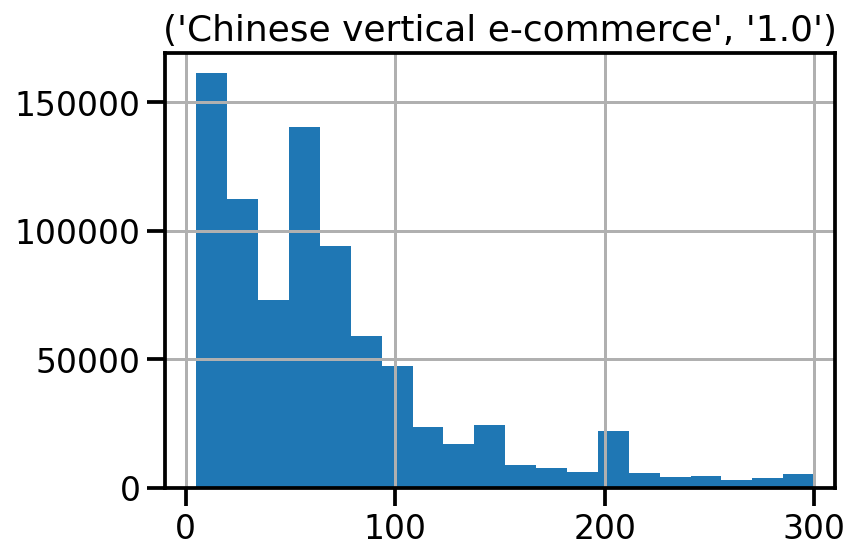

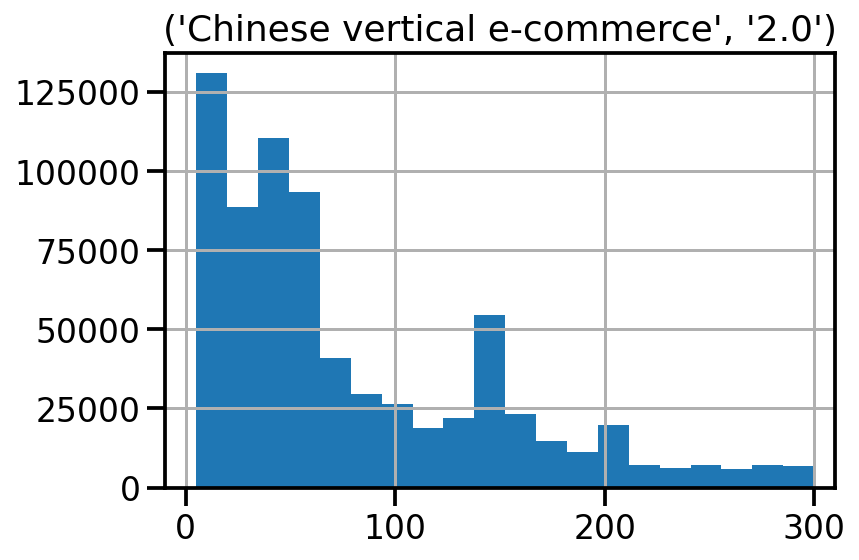

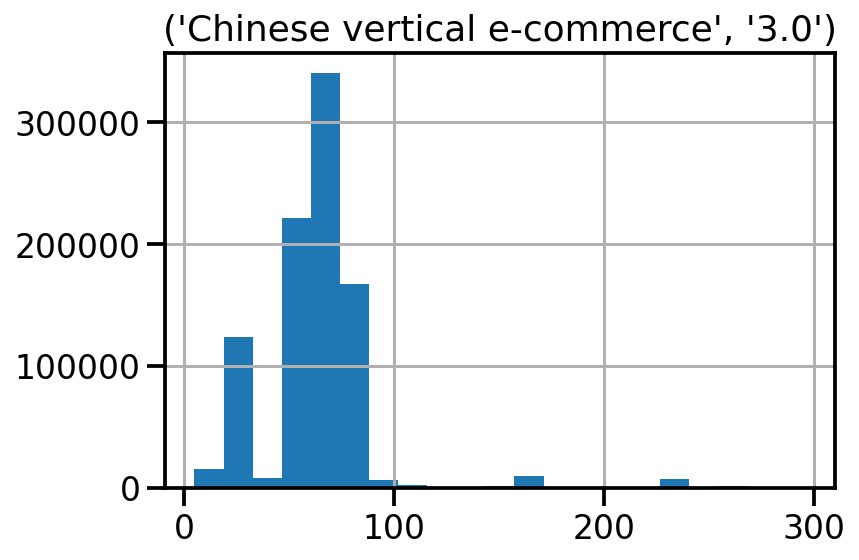

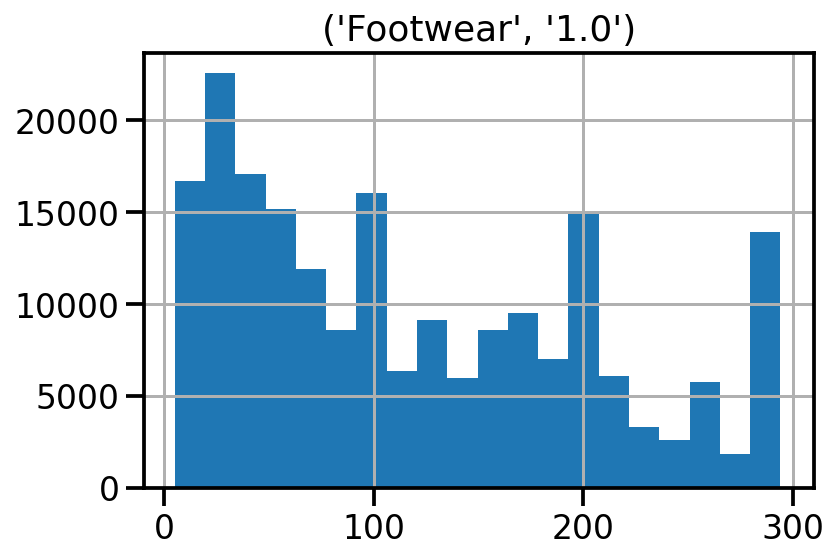

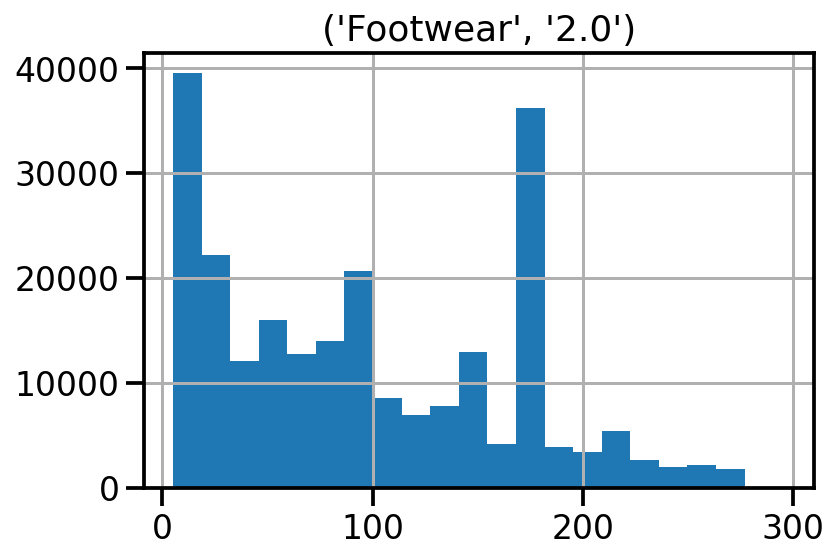

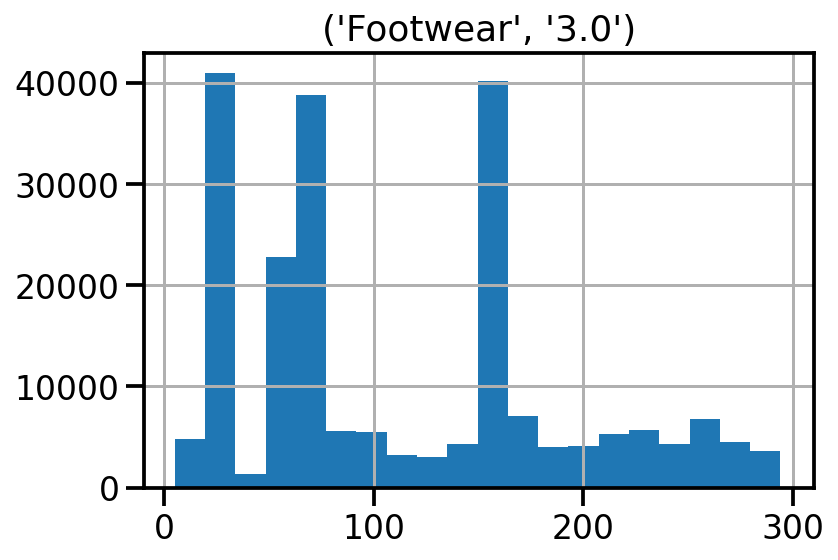

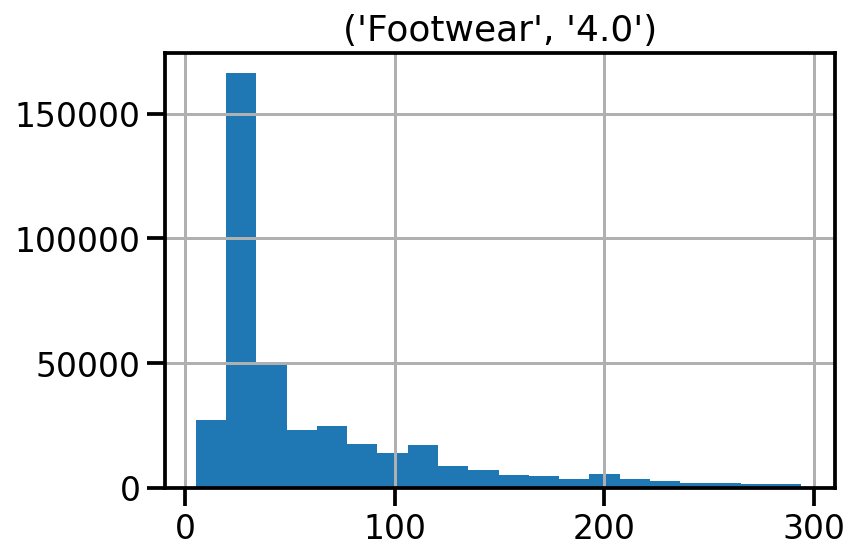

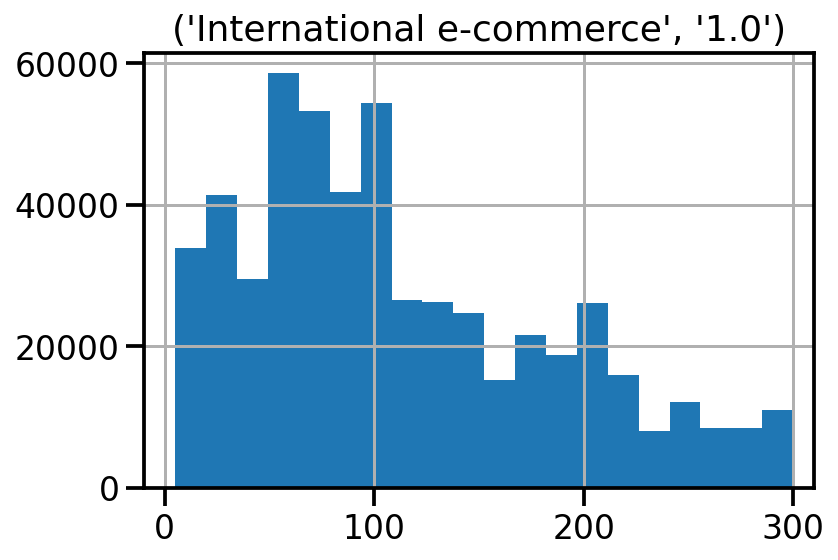

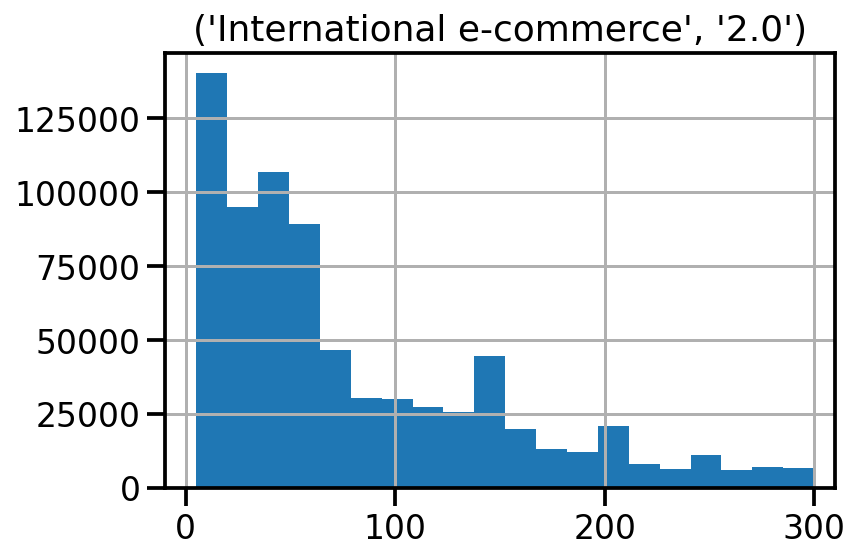

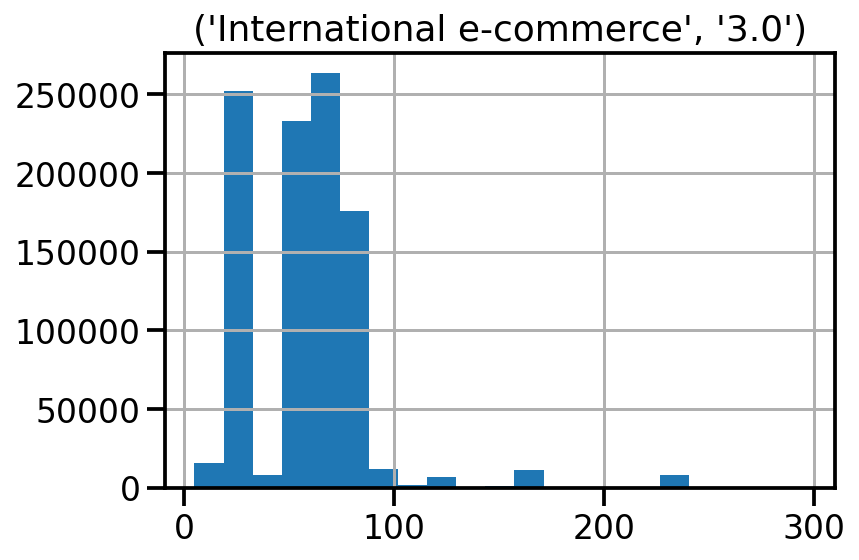

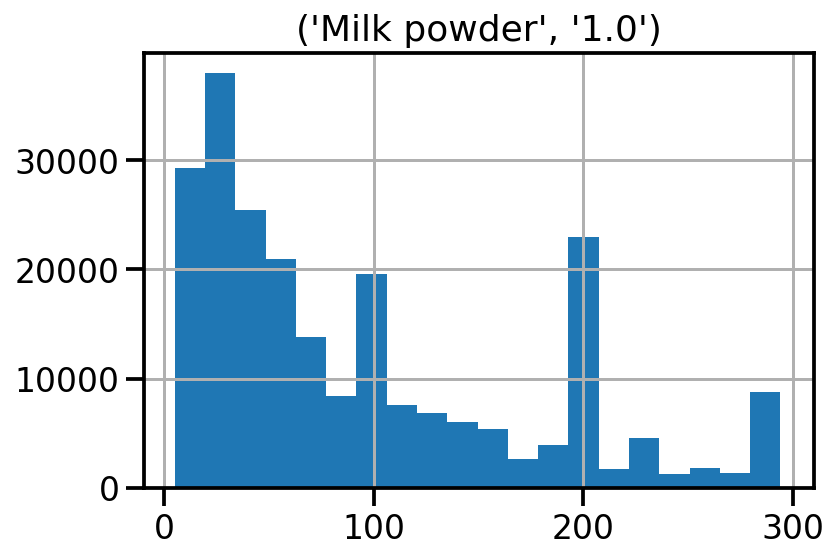

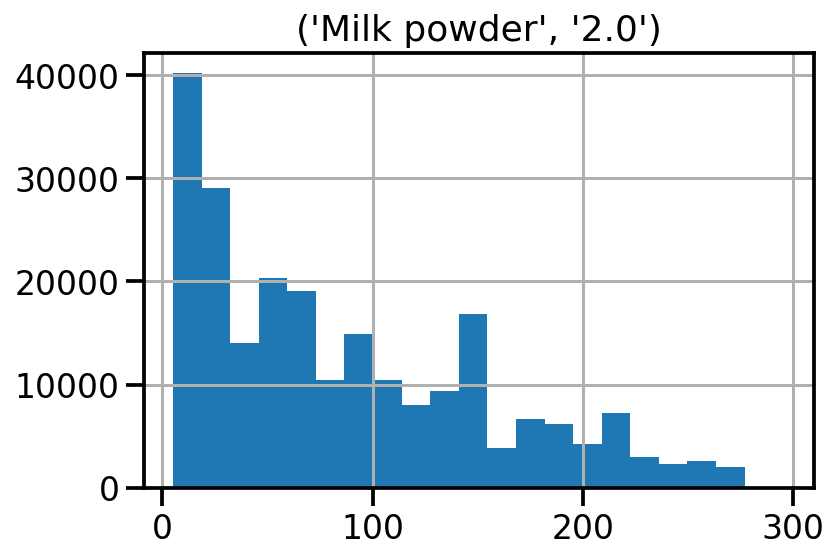

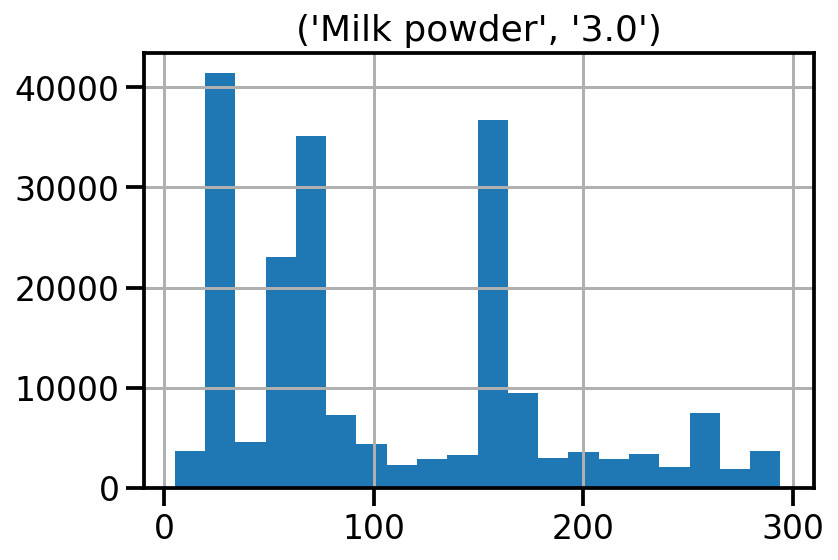

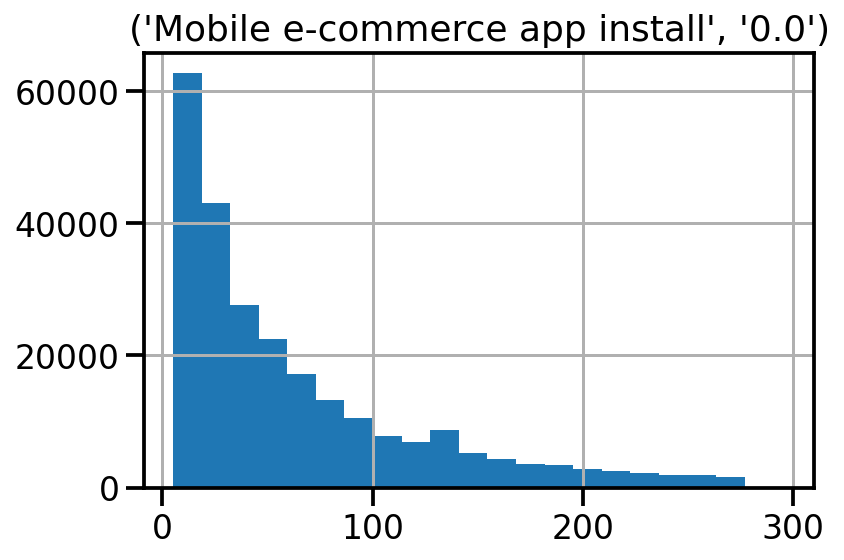

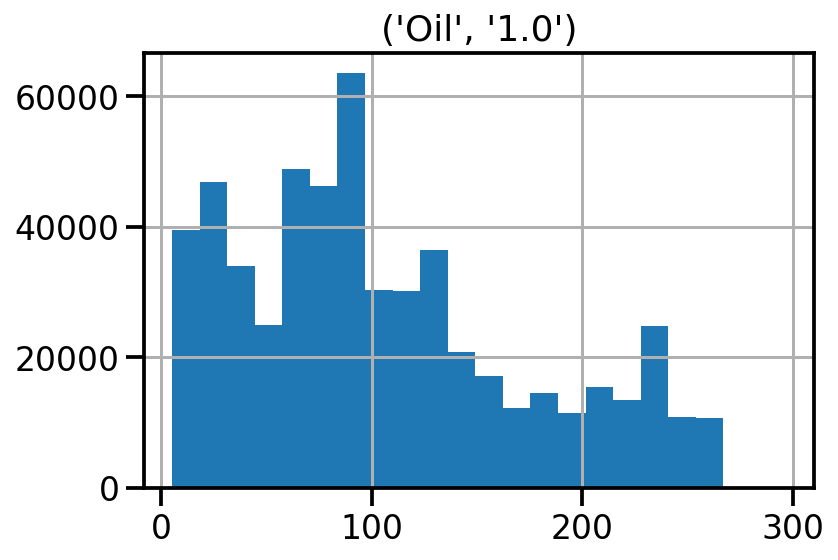

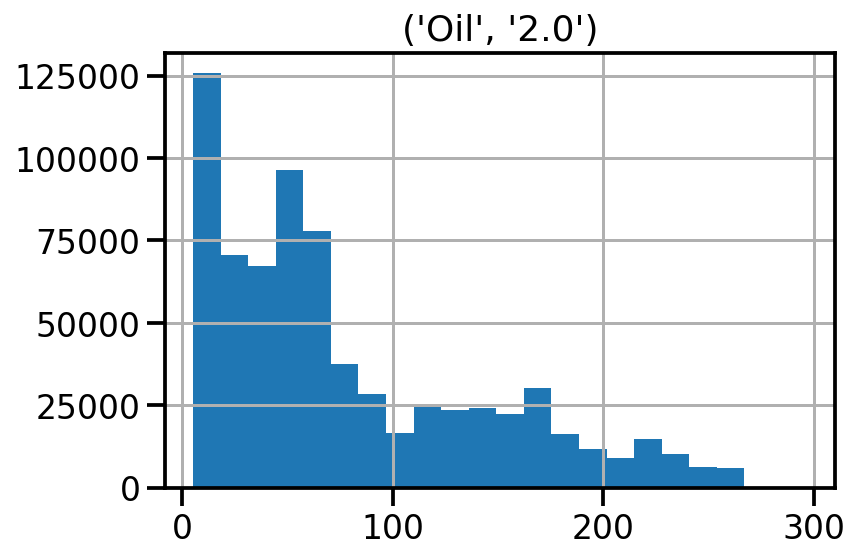

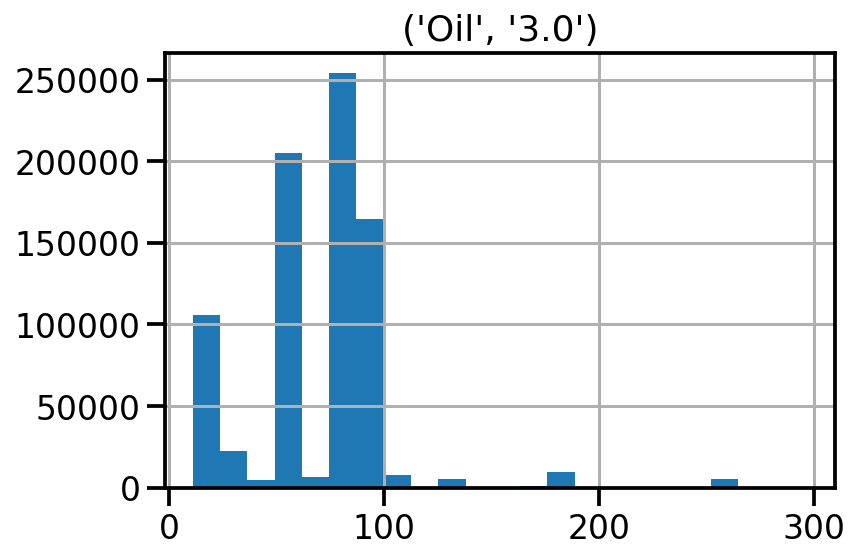

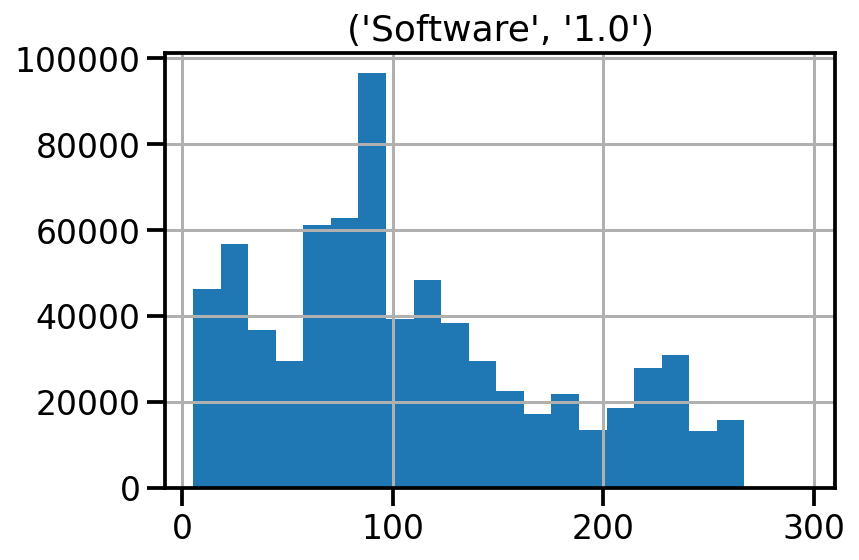

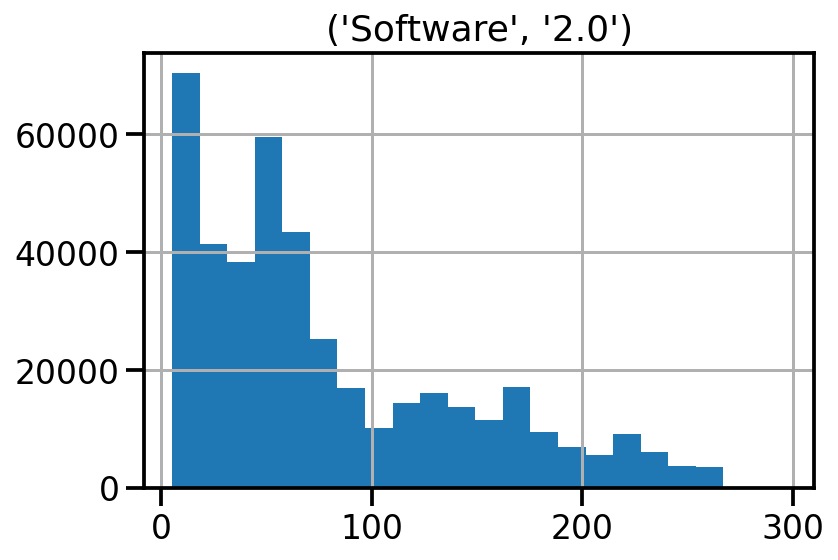

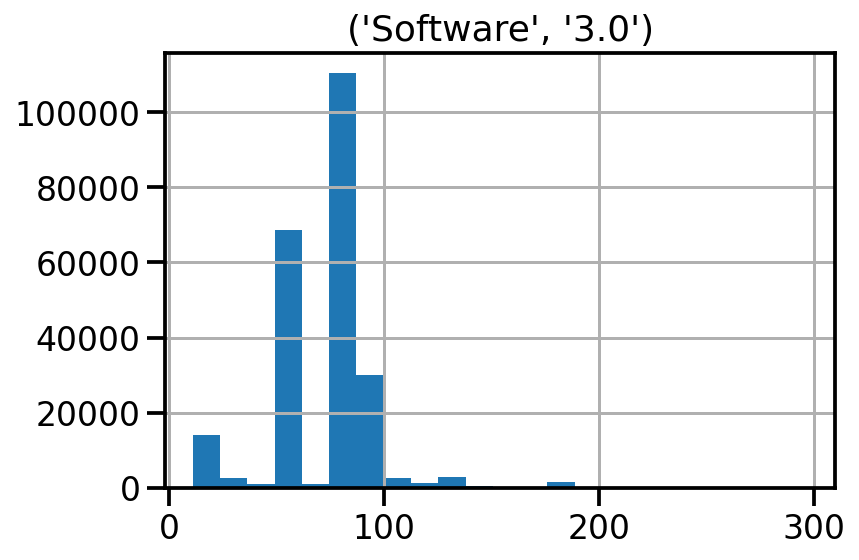

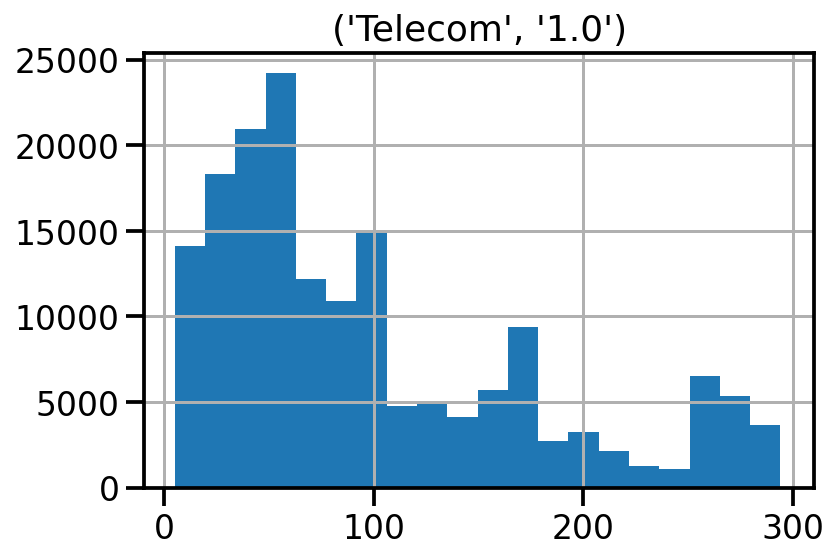

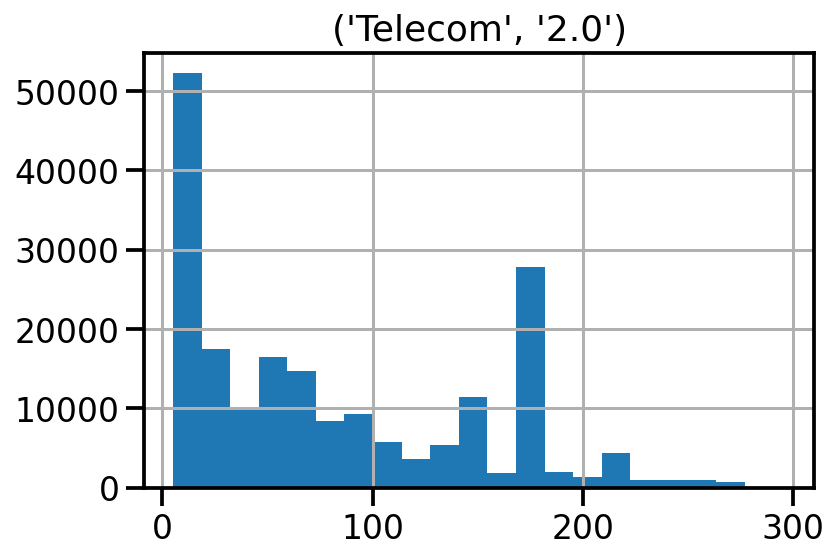

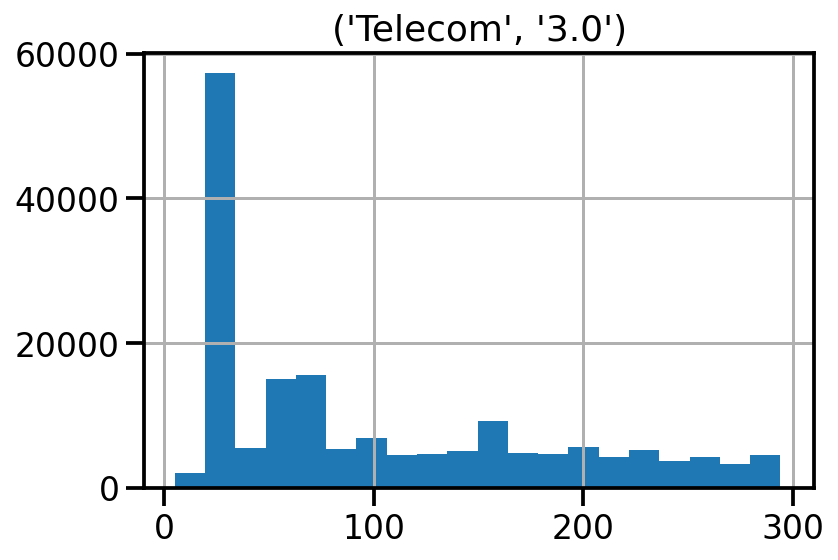

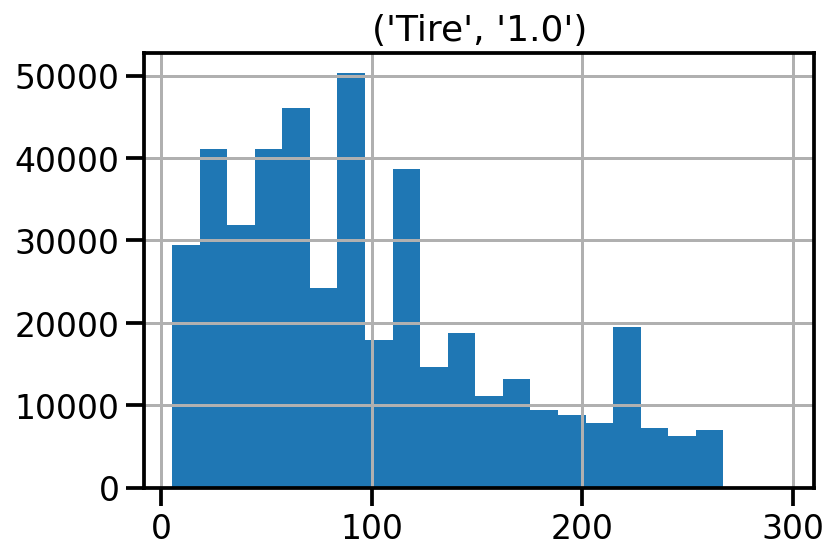

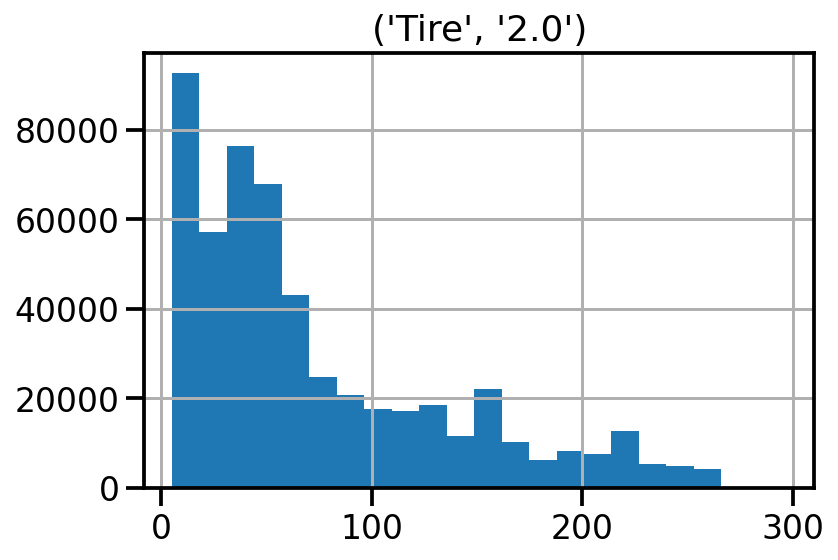

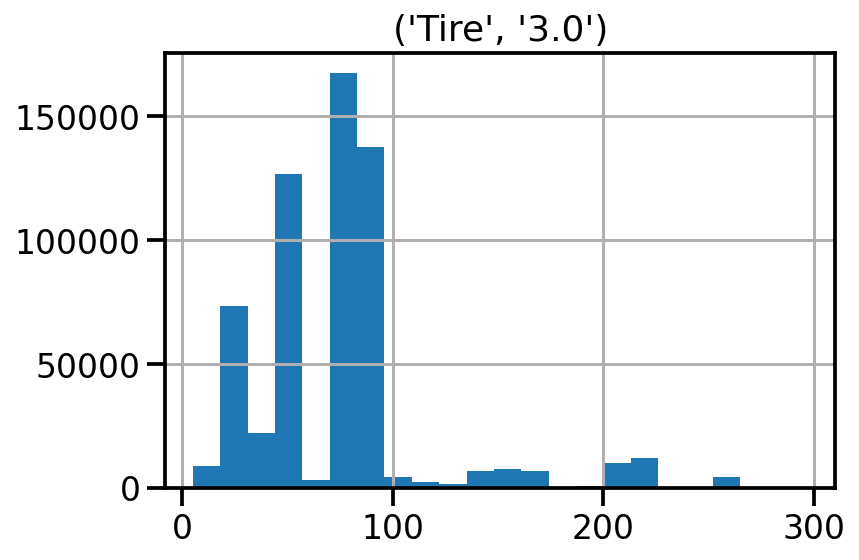

In [7]:
groupby = train.groupby(context_columns)['score']
for group in groupby.groups:
    plt.figure()
    groupby.get_group(group).hist(bins=20)
    plt.title(group)
    plt.xlim(right=310)
    plt.show()

In [8]:
groupby.describe()

count        mean  \
advertiser_category_context   adexchange_context                         
Chinese vertical e-commerce   1.0                 822685.0   68.504595   
                              2.0                 724389.0   79.143634   
                              3.0                 902860.0   62.169752   
Footwear                      1.0                 202969.0  118.654785   
                              2.0                 234550.0   96.857510   
                              3.0                 215878.0  110.374698   
                              4.0                 386375.0   61.472551   
International e-commerce      1.0                 535433.0  112.804614   
                              2.0                 746934.0   78.712368   
                              3.0                 989450.0   56.765560   
Milk powder                   1.0                 230146.0   92.658226   
                              2.0                 230986.0   86.187946   
                              3.0                 202042.0  103.748008   
Mobile e-commerce app install 0.0                 249768.0   62.984858   
Oil                           1.0                 552161.0  104.898805   
                              2.0                 719135.0   78.075060   
                              3.0                 793670.0   68.295494   
Software                      1.0                 725848.0  108.542180   
                              2.0                 422152.0   78.643958   
                              3.0                 236499.0   70.135882   
Telecom                       1.0                 170527.0   97.856199   
                              2.0                 195532.0   81.011456   
                              3.0                 171075.0   97.894175   
Tire                          1.0                 444487.0   97.604591   
                              2.0                 528118.0   72.866954   
                              3.0                 594824.0   72.237033   

                                                        std   min   25%  \
advertiser_category_context   adexchange_context                          
Chinese vertical e-commerce   1.0                 56.796751   5.0  25.0   
                              2.0                 69.025554   5.0  28.0   
                              3.0                 29.149092   5.0  50.0   
Footwear                      1.0                 83.792006   5.0  41.0   
                              2.0                 70.261685   5.0  31.0   
                              3.0                 77.998615   5.0  50.0   
                              4.0                 53.699586   5.0  31.0   
International e-commerce      1.0                 73.024885   5.0  56.0   
                              2.0                 69.273796   5.0  27.0   
                              3.0                 31.572350   5.0  30.0   
Milk powder                   1.0                 77.302621   5.0  30.0   
                              2.0                 68.891675   5.0  25.0   
                              3.0                 75.470011   5.0  50.0   
Mobile e-commerce app install 0.0                 60.692729   5.0  18.0   
Oil                           1.0                 68.215862   5.0  54.0   
                              2.0                 64.659368   5.0  28.0   
                              3.0                 31.518908  11.0  55.0   
Software                      1.0                 68.110905   5.0  60.0   
                              2.0                 64.401920   5.0  29.0   
                              3.0                 22.241696  11.0  55.0   
Telecom                       1.0                 76.078652   5.0  41.0   
                              2.0                 69.580404   5.0  16.0   
                              3.0                 83.078851   5.0  20.0   
Tire                          1.0                 65.354584   5.0  48.0   
                              

# Data Prep

In [7]:
def extract_possible_values(df):
    context_features = dict()
    strategy_features = dict()

    for col in df.columns:
        values = df[col].unique().tolist()
        value_to_ix = {v:i for i,v in enumerate(values)}
        ix_to_value = {i:v for i,v in enumerate(values)}
        values_dict = {
            'values':values,
            'value_to_ix': value_to_ix,
            'ix_to_value': ix_to_value
        }
        if col.endswith('context'):
            context_features[col] = values_dict
        elif col.endswith('score'):
            # Nothing for score
            continue
        else:
            strategy_features[col] = values_dict
    
    result = {'context_features': {'features_order': list(context_features.keys()), 
                                   'features': context_features}, 
              'strategy_features': {'features_order': list(strategy_features.keys()), 
                                   'features': strategy_features}}
    return result

In [10]:
features = extract_possible_values(pd.concat([train, validation, test]))
features

{'context_features': {'features_order': ['advertiser_category_context',
   'adexchange_context'],
  'features': {'advertiser_category_context': {'values': ['Software',
     'International e-commerce',
     'Telecom',
     'Tire',
     'Oil',
     'Milk powder',
     'Footwear',
     'Chinese vertical e-commerce',
     'Mobile e-commerce app install'],
    'value_to_ix': {'Software': 0,
     'International e-commerce': 1,
     'Telecom': 2,
     'Tire': 3,
     'Oil': 4,
     'Milk powder': 5,
     'Footwear': 6,
     'Chinese vertical e-commerce': 7,
     'Mobile e-commerce app install': 8},
    'ix_to_value': {0: 'Software',
     1: 'International e-commerce',
     2: 'Telecom',
     3: 'Tire',
     4: 'Oil',
     5: 'Milk powder',
     6: 'Footwear',
     7: 'Chinese vertical e-commerce',
     8: 'Mobile e-commerce app install'}},
   'adexchange_context': {'values': ['2.0', '3.0', '1.0', '0.0', '4.0'],
    'value_to_ix': {'2.0': 0, '3.0': 1, '1.0': 2, '0.0': 3, '4.0': 4},
    'ix_to_

In [89]:
def df_to_ix_tensors(df, features):
    result_df = df.copy()
    result = {'context_features': dict(), 'strategy_features': dict()}

    for feature_name in features['context_features']['features_order']:
        v_to_ix_f = np.vectorize(features['context_features']['features'][feature_name]['value_to_ix'].__getitem__)
        result['context_features'][feature_name] = torch.from_numpy(v_to_ix_f(result_df[feature_name].values)).long().to(device)

    for feature_name in features['strategy_features']['features_order']:
        v_to_ix_f = np.vectorize(features['strategy_features']['features'][feature_name]['value_to_ix'].__getitem__)
        result['strategy_features'][feature_name] = torch.from_numpy(v_to_ix_f(result_df[feature_name].values)).long().to(device)

    return result

In [9]:
data_ix_tensors = df_to_ix_tensors(train, features)

# Code Chunks & Functions

In [10]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.0, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        return self.pe[x.long()]

def construct_embedding_module(features, emb_dim=512, positional=False):
    
    item_embeddings = dict()
    all_features = list()
    for feature_type in features:
        for col in features[feature_type]['features_order']:
            all_features.append(col)
            if positional:
                item_embeddings[col] = PositionalEncoding(emb_dim, max_len=len(features[feature_type]['features'][col]['values'])+1)
            else:
                item_embeddings[col] = nn.Embedding(len(features[feature_type]['features'][col]['values']), emb_dim)
    item_embeddings = nn.ModuleDict(item_embeddings)

    type_embeddings = nn.Embedding(len(all_features), emb_dim)
    type_to_ix = {v:i for i, v in enumerate(all_features)}
    
    embeddings = nn.ModuleDict({'item_embeddings': item_embeddings,
                             'type_embeddings': type_embeddings})
    return embeddings, type_to_ix

In [51]:
embeddings, type_to_ix = construct_embedding_module(features, emb_dim=32)
embeddings = embeddings.to(device)
embeddings, type_to_ix

(ModuleDict(
   (item_embeddings): ModuleDict(
     (advertiser_category_context): Embedding(9, 32)
     (adexchange_context): Embedding(5, 32)
     (region): Embedding(35, 32)
     (os): Embedding(6, 32)
     (browser): Embedding(9, 32)
     (gender): Embedding(3, 32)
     (slotvisibility): Embedding(11, 32)
     (slotformat): Embedding(4, 32)
     (slotwidth): Embedding(21, 32)
     (slotheight): Embedding(14, 32)
   )
   (type_embeddings): Embedding(10, 32)
 ),
 {'advertiser_category_context': 0,
  'adexchange_context': 1,
  'region': 2,
  'os': 3,
  'browser': 4,
  'gender': 5,
  'slotvisibility': 6,
  'slotformat': 7,
  'slotwidth': 8,
  'slotheight': 9})

In [11]:
def data_ix_tensors_to_input_tensors(data_ix_tensors, embeddings, features, type_to_ix ):
    
    first_context_column = features['context_features']['features_order'][0]
    batch_size = len(data_ix_tensors['context_features'][first_context_column])

    input_tensors = list()
    for col in features['context_features']['features_order']:
        t = data_ix_tensors['context_features'][col]
        value_embedding = embeddings['item_embeddings'][col](t)

        type_ix_t = torch.tensor([[type_to_ix[col]]], dtype=torch.int, device=device).expand(batch_size,1)
        type_embedding = embeddings['type_embeddings'](type_ix_t)

        final_embedding = value_embedding + type_embedding
        input_tensors.append(final_embedding)
    
    for col in features['strategy_features']['features_order']:
        d = features['strategy_features']['features'][col]
        ixs = torch.arange(0, len(d['values']), dtype=torch.int, device=device).expand(batch_size,-1)
        value_embedding = embeddings['item_embeddings'][col](ixs)

        type_ix_t = torch.tensor([[type_to_ix[col]]], dtype=torch.int, device=device).expand(batch_size,len(d['values']))
        type_embedding = embeddings['type_embeddings'](type_ix_t)

        final_embedding = value_embedding + type_embedding
        input_tensors.append(final_embedding)

    input_tensors = torch.cat(input_tensors, 1) #shape: (batch_size, all_vocab_len, embedding_dim)

    return input_tensors #shape: (batch_size, all_vocab_len, embedding_dim)

In [14]:
input_tensor = data_ix_tensors_to_input_tensors(data_ix_tensors, embeddings, features, type_to_ix)
input_tensor.size()

torch.Size([2000, 2108, 32])

In [12]:
def get_decoder_input_and_target_tensor(data_ix_tensors, embeddings, features, type_to_ix, batch_size):

    decoder_target_tensor = list()
    decoder_input_tensor = list()
    
    for col in features['strategy_features']['features_order']:
        decoder_target_tensor.append(data_ix_tensors['strategy_features'][col].view((-1,1)))

        type_ix_t = torch.tensor([[type_to_ix[col]]], dtype=torch.int, device=device).expand(batch_size,1)

        type_embedding = embeddings['type_embeddings'](type_ix_t)

        decoder_input_tensor.append(type_embedding)
    
    decoder_input_tensor = torch.cat(decoder_input_tensor,1) #shape: (batch_size, sequence_len, embedding_dim)
    decoder_target_tensor = torch.cat(decoder_target_tensor,1) #shape: (batch_size, sequence_len)

    return decoder_input_tensor, decoder_target_tensor

In [ ]:
batch_size = input_tensor.shape[0]
decoder_input_tensor, decoder_target_tensor = get_decoder_input_and_target_tensor(data_ix_tensors, embeddings, features, type_to_ix, batch_size)
decoder_input_tensor.shape, decoder_target_tensor.shape

In [13]:
def map_tensor(t, mapping):
    palette, key = zip(*sorted(mapping.items()))
    key = torch.tensor(key, device=device)
    palette = torch.tensor(palette, device=device)
    index = torch.bucketize(t, palette)
    return key[index]

# Performance Estimator

In [45]:
experiment_name = 'ipinyou_estimator_standard_features'
mlflow.set_experiment(experiment_name)

run = mlflow.start_run()

In [14]:
import sys
sys.path.append('.')
from mlframework.pytorch.models import CrossNetMix


class ipinyouPriceMdeler(nn.Module):

    def __init__(self, features, embedding_dim, latent_dim, normalizers, denormalizers, output_size = 2):
        super(ipinyouPriceMdeler, self).__init__()

        self.features = features
        self.embedding_dim = embedding_dim
        self.latent_dim = latent_dim
        self.normalizers = normalizers
        self.denormalizers = denormalizers

        embeddings, type_to_ix = construct_embedding_module(features, emb_dim=embedding_dim)
        self.embeddings = embeddings
        #nn.init.xavier_uniform_(self.embeddings.weight)
        
        nb_numerical = len(normalizers) - 1   # -1 to not count goal dimension
        nb_categorical = len(features['context_features']['features_order'] + features['strategy_features']['features_order']) - nb_numerical 
        input_dim = (nb_categorical * embedding_dim) + nb_numerical
        self.linear1 = nn.Linear( input_dim, 128)
        self.linear2 = nn.Linear(128, 64)
        self.latent = nn.Linear(64 + input_dim, latent_dim)

        self.final_layer = nn.Linear(latent_dim, output_size)
        
        self.dcn = CrossNetMix(input_dim, layer_num=3, low_rank=32, num_experts=4)
    
    def forward(self, data_ix_tensors):
        
        input_tensor = self.data_ix_tensors_to_input(data_ix_tensors)
        
        lt = self.to_latent(input_tensor)
        out = self.final_layer(lt)
        
        return out

    def data_ix_tensors_to_input(self, data_ix_tensors):
        input_tensor = list()
        for col in self.features['context_features']['features_order']:
            t = data_ix_tensors['context_features'][col]
            value_embedding = self.embeddings['item_embeddings'][col](t)
            input_tensor.append(value_embedding)

        for col in self.features['strategy_features']['features_order']:
            if col in self.normalizers:
                mapping = self.features['strategy_features']['features'][col]['ix_to_value']
                tn = data_ix_tensors['strategy_features'][col]
                tn = self.normalizers[col](map_tensor(tn, mapping)).view(-1,1)
                input_tensor.append(tn)
            else:
                t = data_ix_tensors['strategy_features'][col]
                value_embedding = self.embeddings['item_embeddings'][col](t).squeeze()
                input_tensor.append(value_embedding)

        input_tensor = torch.cat(input_tensor,1)
        return input_tensor


    def to_latent(self, input_tensor):

        out1 = F.relu(self.linear1(input_tensor))
        out2 = self.linear2(out1)

        dcn_out = self.dcn(input_tensor)
        if len(dcn_out.size()) == 1:
            dcn_out = dcn_out.view(1,-1)
            
        combined = F.relu(torch.cat([dcn_out, out2], dim=-1))
        
        #out = self.linear3(out2)
        lt = torch.sigmoid(self.latent(combined))
        return lt

In [ ]:
def chosen_dist(inputs):
    mean, scale_softplus = inputs[:,0], inputs[:,1]
    return torch.distributions.gamma.Gamma(mean, scale_softplus)


#training loop
epochs = 1000
patience = 20
og_patience = patience
train_losses = []
test_losses = []
validation_losses = []
latent_dim = 10
emb_dim = 6
lr=0.001
weight_decay=1e-5
model_args = (features, emb_dim, latent_dim, normalizers, denormalizers)
model = ipinyouPriceMdeler(*model_args)
model = nn.DataParallel(model)
batch_size = 1024

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

mlflow.log_params(
    {'learning_rate':lr,
    'weight_decay':weight_decay,
    'batch_size':batch_size,
    'latent_dim':latent_dim,
    'emb_dim':emb_dim})

model = model.to(device)
best_model = None
best_val_loss = np.inf

for epoch in range(epochs):
    total_loss = 0
    model.train()
    for i in tqdm(range(0, len(train), batch_size), desc=f"Epoch {epoch} training"):

        batch_data = train[i: i+batch_size]

        data_ix_tensors = df_to_ix_tensors(batch_data, features)

        optimizer.zero_grad()
        output = model(data_ix_tensors)
        output_softplus = F.softplus(output)

        normals = chosen_dist(output_softplus)
        prices = torch.tensor(normalizers[performance_columns[0]](batch_data['score']).values, device=device)
        log_probs = normals.log_prob(prices)
        anlp_loss = -torch.sum(log_probs)

        loss = anlp_loss
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()

        total_loss += loss.item()

    
    train_loss = total_loss/len(train)
    train_losses.append(train_loss)


    with torch.no_grad():
        total_loss = 0
        model.eval()
        for i in tqdm(range(0, len(validation), batch_size), desc=f"Epoch {epoch} validation"):
            batch_data = validation[i: i+batch_size]

            data_ix_tensors = df_to_ix_tensors(batch_data, features)

            output = model(data_ix_tensors)
            output_softplus = F.softplus(output)

            normals = chosen_dist(output_softplus)
            prices = torch.tensor(normalizers[performance_columns[0]](batch_data['score']).values, device=device)
            log_probs = normals.log_prob(prices)
            anlp_loss = -torch.sum(log_probs)

            loss = anlp_loss

            total_loss += loss.item()
        
        validation_loss = total_loss/len(validation)
        validation_losses.append(validation_loss)

    if epoch % 1 == 0:

        print_tqdm(f'Epoch {epoch} train loss {train_loss:0.5} validation loss {validation_loss:0.5}')

        if validation_loss < best_val_loss:
            best_val_loss = validation_loss
            best_model = copy.deepcopy(model.state_dict())
            patience = og_patience
        else:
            patience -= 1
        if patience < 0:
            break

    mlflow.log_metric('train_loss', train_loss, step=epoch)
    mlflow.log_metric('validation_loss', validation_loss, step=epoch)
    
model.load_state_dict(best_model)

In [46]:
model.load_state_dict(best_model)

<All keys matched successfully>

In [16]:
# calculate prediction price, index of prediction price
unique_only = True  # group by features, mean price per feature
impression_threshold = 5
lps = []
p = []
z = []
batch_size = 1024

with torch.no_grad():
    model.eval()
    df = test
    if unique_only:
        feature_cols = features['context_features']['features_order'] + features['strategy_features']['features_order']
        x = df.groupby(feature_cols).agg(
            score=pd.NamedAgg(column='score', aggfunc='mean'), 
            volume=pd.NamedAgg(column='score', aggfunc='count')
        )
        before = len(x)
        x = x[x['volume'] >= impression_threshold]
        after = len(x)
        print(f'Filtered over {impression_threshold} impressions only')
        print(f'Filtered from {before} to {after}, remaining data {after*100/before:.3} %')
        df = x.reset_index()

    for i in tqdm(range(0, len(df), batch_size)):
        batch_data = df[i: i+batch_size]

        data_ix_tensors = df_to_ix_tensors(batch_data, features)

        output = model(data_ix_tensors)
        output_softplus = F.softplus(output)

        normals = chosen_dist(output_softplus)
        prices = torch.tensor(normalizers[performance_columns[0]](batch_data['score']).values, device=device)
        log_probs = normals.log_prob(prices)
        anlp_loss = -torch.sum(log_probs)

        p += denormalizers[performance_columns[0]](normals.mean).tolist()
        z += denormalizers[performance_columns[0]](prices).tolist()
        lps += log_probs.tolist()

Filtered over 5 impressions only
Filtered from 110535 to 46340, remaining data 41.9 %


In [17]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import roc_auc_score

def evaluate(lps, p, z):
    anlp = lps
    mae = mean_absolute_error(p, z)
    real_means = np.array(z)
    predicted_means = np.array(p)
    proportions = np.abs((real_means - predicted_means)/real_means)
    
    anlp_loss = -sum(anlp)/len(anlp)
    proportion = proportions.mean()

    print('MAE = {:.2f}'.format(mae))
    print('ANLP =', str(anlp_loss))
    print('PROPORTION = {:.2f}'.format(proportion))

    mlflow.log_metric('MAE test', mae)
    mlflow.log_metric('ANLP test', anlp_loss)
    mlflow.log_metric('PROPORTION test', proportion)

evaluate(lps, p, z)

MAE = 18.41
ANLP = 1.7496676506635396
PROPORTION = 0.21


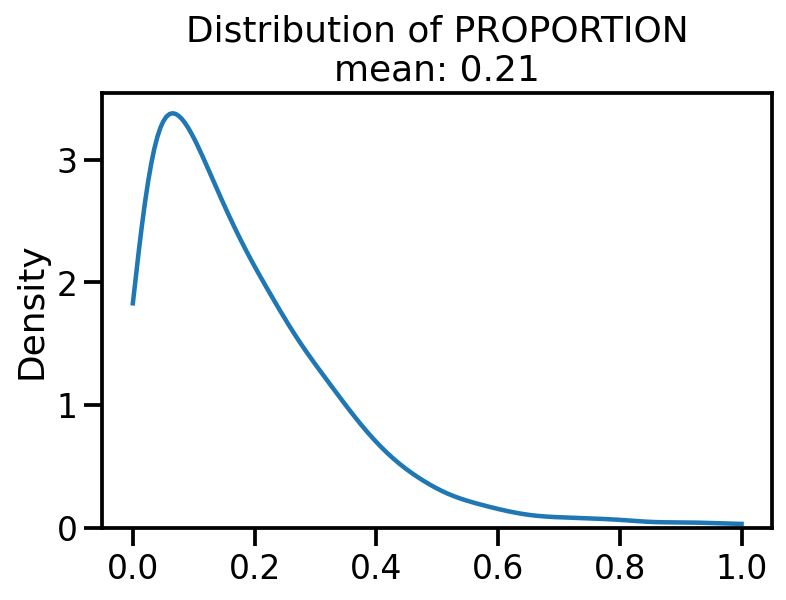

In [25]:
real_means = np.array(z)
predicted_means = np.array(p)
test_mean_mae = np.abs((real_means - predicted_means)/real_means)
sns.kdeplot(test_mean_mae, label='estimated', clip=(0,1))
_ = plt.title(f'Distribution of PROPORTION\nmean: {test_mean_mae.mean():0.2f}')

In [127]:
estimator = model

features_path = 'mlflow_artifacts/ipinyou_standard_features'
estimator_path = 'mlflow_artifacts/ipinyou_estimator_standard_features'
torch.save(features, features_path)
torch.save(estimator.module.state_dict(), estimator_path)
mlflow.log_artifact(features_path)
mlflow.log_artifact(estimator_path)

In [130]:
mlflow.end_run()

# Strategy Generator

In [101]:
experiment_name = 'ipinyou_strategy_generator_standard_features'
mlflow.set_experiment(experiment_name)

run = mlflow.start_run()

In [18]:
class BaseModel(nn.Module):

    def __init__(self, features: dict, emb_size: int, n_head:int, n_layers:int, 
                        ffn_expansion: float = 4, dropout: float = 0.2, use_interaction=True, positional_encodings=False, n_sampling_choices=0):
        super().__init__()
        self.model_type = 'Transformer'

        self.features = features
        self.emb_size = emb_size
        self.n_layers = n_layers
        self.n_head = n_head
        self.ffn_expansion = ffn_expansion
        self.n_sampling_choices = n_sampling_choices

        #EMBEDDINGS
        embeddings, type_to_ix = construct_embedding_module(features, emb_dim=emb_size, positional=positional_encodings)
        self.embeddings = embeddings
        self.type_to_ix = type_to_ix

        #SAMPLING
        if self.n_sampling_choices > 0:
            self.sampling_embeddings = nn.Embedding(n_sampling_choices, emb_size)
            self.sampling_embeddings.weight.requires_grad = False
            #self.register_buffer('sampling_embeddings', sampling_embeddings)
        
        #ENCODER
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_size, nhead=n_head, batch_first=True, norm_first=True, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        #DECODER
        decoder_layer = nn.TransformerDecoderLayer(d_model=emb_size, nhead=n_head, batch_first=True, norm_first=True, dropout=dropout)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=n_layers)
        
        #FFNs
        ffns = dict()
        for strategy_feature in features['strategy_features']['features_order']:
            vocab_size = len(features['strategy_features']['features'][strategy_feature]['values'])
            ffns[strategy_feature] =  nn.Sequential(
                nn.Linear(emb_size, int(emb_size*ffn_expansion), bias=False),
                nn.LeakyReLU(),
                nn.Linear(int(emb_size*ffn_expansion), vocab_size, bias=False),
                )
        self.ffns = nn.ModuleDict(ffns)
        #self.interaction_layer = CrossNetMix(emb_size*len(features['strategy_features']['features_order']), layer_num=3, low_rank=32, num_experts=4)

        self.init_weights()

    def init_weights(self) -> None:
        pass

    def forward(self, data_ix_tensors, chosen_samples=None):
        
        #ENCODER
        input_tensor = self.get_encoder_input_tensors(data_ix_tensors, chosen_samples=chosen_samples)
        encoder_output = self.transformer_encoder(input_tensor) #shape: (batch_size, sequence_len, embedding_dim)

        #DECODER
        batch_size = input_tensor.shape[0]
        decoder_input_tensor = self.get_decoder_input_tensor(batch_size)
        decoder_output = self.transformer_decoder(decoder_input_tensor, encoder_output)

        #FFNs
        result = dict()
        for feature_ix, strategy_feature in enumerate(self.features['strategy_features']['features_order']):
            result[strategy_feature] = self.ffns[strategy_feature](decoder_output[:,feature_ix,:])

        return result


    def get_encoder_input_tensors(self, data_ix_tensors, chosen_samples=None):
    
        first_context_column = self.features['context_features']['features_order'][0]
        batch_size = len(data_ix_tensors['context_features'][first_context_column])

        input_tensors = list()

        if (chosen_samples is None) and (self.n_sampling_choices > 0):
            rt = torch.randint(self.n_sampling_choices, (batch_size,1), device=device)
            sampled_embeddings = self.sampling_embeddings(rt)
            input_tensors.append(sampled_embeddings) #shape: (batch_size, 1, emb_dim)
        if chosen_samples is not None:
            sampled_embeddings = self.sampling_embeddings(chosen_samples)
            input_tensors.append(sampled_embeddings) #shape: (batch_size, 1, emb_dim)

        for col in self.features['context_features']['features_order']:
            t = data_ix_tensors['context_features'][col]
            value_embedding = self.embeddings['item_embeddings'][col](t) #shape: (batch_size, emb_dim)

            type_ix_t = torch.tensor(self.type_to_ix[col], dtype=torch.int, device=device).expand(batch_size)
            type_embedding = self.embeddings['type_embeddings'](type_ix_t) #shape: (batch_size, emb_dim)

            final_embedding = value_embedding + type_embedding #shape: (batch_size, emb_dim)
            input_tensors.append(final_embedding.unsqueeze(1)) #shape: (batch_size, 1, emb_dim)
        
        for col in self.features['strategy_features']['features_order']:
            d = self.features['strategy_features']['features'][col]
            ixs = torch.arange(0, len(d['values']), dtype=torch.int, device=device).expand(batch_size,-1)
            value_embedding = self.embeddings['item_embeddings'][col](ixs) #shape: (batch_size, current_feature_vocab_len, emb_dim)

            type_ix_t = torch.tensor(self.type_to_ix[col], dtype=torch.int, device=device).expand(batch_size,len(d['values']))
            type_embedding = self.embeddings['type_embeddings'](type_ix_t) #shape: (batch_size, current_feature_vocab_len, emb_dim)

            final_embedding = value_embedding + type_embedding #shape: (batch_size, current_feature_vocab_len, emb_dim)
            input_tensors.append(final_embedding)

        input_tensors = torch.cat(input_tensors, 1) #shape: (batch_size, all_vocab_len, embedding_dim)
        return input_tensors #shape: (batch_size, all_vocab_len, embedding_dim)


    def get_decoder_input_tensor(self, batch_size):

        decoder_input_tensor = list()
        
        for col in self.features['strategy_features']['features_order']:
            type_ix_t = torch.tensor([[self.type_to_ix[col]]], dtype=torch.int, device=device).expand(batch_size,1)
            type_embedding = self.embeddings['type_embeddings'](type_ix_t)
            decoder_input_tensor.append(type_embedding)
        
        decoder_input_tensor = torch.cat(decoder_input_tensor,1) #shape: (batch_size, sequence_len, embedding_dim)

        return decoder_input_tensor

In [19]:
def get_target_tensor(data_ix_tensors, features):
    decoder_target_tensor = list()
    for col in features['strategy_features']['features_order']:
        decoder_target_tensor.append(data_ix_tensors['strategy_features'][col].view((-1,1)))
    decoder_target_tensor = torch.cat(decoder_target_tensor,1) #shape: (batch_size, sequence_len)
    return decoder_target_tensor

In [22]:
train.groupby(features['context_features']['features_order'])['score'].describe()

count        mean  \
advertiser_category_context   adexchange_context                         
Chinese vertical e-commerce   1.0                 822685.0   68.504595   
                              2.0                 724389.0   79.143634   
                              3.0                 902860.0   62.169752   
Footwear                      1.0                 202969.0  118.654785   
                              2.0                 234550.0   96.857510   
                              3.0                 215878.0  110.374698   
                              4.0                 386375.0   61.472551   
International e-commerce      1.0                 535433.0  112.804614   
                              2.0                 746934.0   78.712368   
                              3.0                 989450.0   56.765560   
Milk powder                   1.0                 230146.0   92.658226   
                              2.0                 230986.0   86.187946   
                              3.0                 202042.0  103.748008   
Mobile e-commerce app install 0.0                 249768.0   62.984858   
Oil                           1.0                 552161.0  104.898805   
                              2.0                 719135.0   78.075060   
                              3.0                 793670.0   68.295494   
Software                      1.0                 725848.0  108.542180   
                              2.0                 422152.0   78.643958   
                              3.0                 236499.0   70.135882   
Telecom                       1.0                 170527.0   97.856199   
                              2.0                 195532.0   81.011456   
                              3.0                 171075.0   97.894175   
Tire                          1.0                 444487.0   97.604591   
                              2.0                 528118.0   72.866954   
                              3.0                 594824.0   72.237033   

                                                        std   min   25%  \
advertiser_category_context   adexchange_context                          
Chinese vertical e-commerce   1.0                 56.796751   5.0  25.0   
                              2.0                 69.025554   5.0  28.0   
                              3.0                 29.149092   5.0  50.0   
Footwear                      1.0                 83.792006   5.0  41.0   
                              2.0                 70.261685   5.0  31.0   
                              3.0                 77.998615   5.0  50.0   
                              4.0                 53.699586   5.0  31.0   
International e-commerce      1.0                 73.024885   5.0  56.0   
                              2.0                 69.273796   5.0  27.0   
                              3.0                 31.572350   5.0  30.0   
Milk powder                   1.0                 77.302621   5.0  30.0   
                              2.0                 68.891675   5.0  25.0   
                              3.0                 75.470011   5.0  50.0   
Mobile e-commerce app install 0.0                 60.692729   5.0  18.0   
Oil                           1.0                 68.215862   5.0  54.0   
                              2.0                 64.659368   5.0  28.0   
                              3.0                 31.518908  11.0  55.0   
Software                      1.0                 68.110905   5.0  60.0   
                              2.0                 64.401920   5.0  29.0   
                              3.0                 22.241696  11.0  55.0   
Telecom                       1.0                 76.078652   5.0  41.0   
                              2.0                 69.580404   5.0  16.0   
                              3.0                 83.078851   5.0  20.0   
Tire                          1.0                 65.354584   5.0  48.0   
                              

In [20]:
stats = train.groupby(features['context_features']['features_order']).agg(
                min=pd.NamedAgg(column='score', aggfunc='min'), 
                mean=pd.NamedAgg(column='score', aggfunc='mean'),
                max=pd.NamedAgg(column='score', aggfunc='max')
            )   
stats

min        mean  max
advertiser_category_context   adexchange_context                      
Chinese vertical e-commerce   1.0                   5   68.504595  300
                              2.0                   5   79.143634  300
                              3.0                   5   62.169752  282
Footwear                      1.0                   5  118.654785  294
                              2.0                   5   96.857510  277
                              3.0                   5  110.374698  294
                              4.0                   5   61.472551  294
International e-commerce      1.0                   5  112.804614  300
                              2.0                   5   78.712368  300
                              3.0                   5   56.765560  282
Milk powder                   1.0                   5   92.658226  294
                              2.0                   5   86.187946  277
                              3.0                   5  103.748008  294
Mobile e-commerce app install 0.0                   5   62.984858  277
Oil                           1.0                   5  104.898805  267
                              2.0                   5   78.075060  267
                              3.0                  11   68.295494  265
Software                      1.0                   5  108.542180  267
                              2.0                   5   78.643958  267
                              3.0                  11   70.135882  265
Telecom                       1.0                   5   97.856199  294
                              2.0                   5   81.011456  277
                              3.0                   5   97.894175  294
Tire                          1.0                   5   97.604591  267
                              2.0                   5   72.866954  266
                              3.0                   5   72.237033  265

In [21]:
def score_positiveness(batch_data, score_tensor, stats_df, features, min_anchor_positiveness=0.05, max_anchor_positiveness=None, c_scaling=1, contexts=None):
    if contexts != None:
        tmp = stats.loc[contexts]
    else:
        tmp = stats.loc[batch_data[features['context_features']['features_order']].to_records(index=False).tolist()]
    c = tmp['mean'].values*c_scaling
    min_anchors = tmp['min'].values
    min_g = np.log((1/min_anchor_positiveness)-1)/(c-min_anchors)
    min_l = c*min_g

    min_g = torch.tensor(min_g, device=device)
    min_l = torch.tensor(min_l, device=device)
    p = 1/(1 + torch.exp( min_l - min_g*score_tensor ))

    if max_anchor_positiveness != None:
        max_anchors = tmp['max'].values
        max_g = np.log((1/max_anchor_positiveness)-1)/(c-max_anchors)
        max_l = c*max_g

        max_g = torch.tensor(max_g, device=device)
        max_l = torch.tensor(max_l, device=device)
        new_p = 1/(1 + torch.exp( max_l - max_g*score_tensor ))
        p = torch.minimum(p, new_p)

    return p

In [22]:
def positive_curve(x, y, eiw=1, dfw=0.005):
    # eiw (estimator ignorance weight) : higher value means we don't care about estimator
    # dfw (data fidelity weight) : higher value means we want reconstruction of good strategy
    # (high eiw, high dfw): target a good strategy even if it has bad score estimation
    # (high eiw, low dfw): target a good strategy WITH good estimation
    # (low eiw, high dfw): target either good strategy OR well estimated other
    # (low eiw, low dfw): target any well estimated other (almost ignore data)
    return torch.exp((y-eiw)/eiw)+dfw*torch.pow(x,2)*(torch.pow(y,2)+1)

def average_curve(x, y, eiw=0.5, aaw=2):
    # eiw (estimator ignorance weight) : higher value means we don't care about estimator
    # aaw (average avoidance weight) : higher value means we want to avoid reconstructing neutral strategy
    return torch.exp((y-eiw)/eiw) + aaw/(x+1) 

def negative_curve(x, y, nfw=40, new=1):
    # nfw (negative force weight) : higher value means want to avoid negative strategy more
    return (nfw*torch.exp(y))/(x+0.1) + y*torch.exp(new*y)

def L(reconstruction_l, score_l, p, peiw=1, pdfw=0.005, aeiw=0.5, aaw=2, nfw=40, new=1 ):
    pos = torch.clamp(2*p-1, 0)
    neg = torch.clamp(1-2*p, 0)
    avg = 2*(1-torch.max(p, 1-p))

    x = reconstruction_l
    y = score_l

    return pos*positive_curve(x, y, eiw=peiw, dfw=pdfw) + avg*average_curve(x, y, eiw=aeiw, aaw=aaw) + neg*negative_curve(x, y, nfw=nfw, new=new)
mlflow.set_tag("Loss Combination", "smooth")

'\ndef L(reconstruction_l, score_l, p, peiw=1, pdfw=0.005, aeiw=0.5, aaw=2, nfw=40, new=1 ):\n    pos = p > 0.8\n    neg = p < 0.5\n\n    x = reconstruction_l\n    y = score_l\n\n    total_loss = average_curve(x, y, eiw=aeiw, aaw=aaw)\n    total_loss[pos] = positive_curve(x[pos], y[pos], eiw=peiw, dfw=pdfw)\n    total_loss[neg] = negative_curve(x[neg], y[neg], nfw=nfw, new=new)\n    return total_loss\n\nmlflow.set_tag("Loss Combination", "thresholded")\n'

In [23]:
def generated_to_data_ix_tensors(output, data_ix_tensors, features, sampling=False):
    generated = {
        'strategy_features': dict(),
        'context_features': dict()
    }
    confidences = 0
    for k in features['strategy_features']['features_order']:
        softmaxes = F.softmax(output[k].detach(), dim=1)
        if sampling:
            value = torch.multinomial(softmaxes, 1, replacement=True)
        else:
            value = softmaxes.argmax(1).unsqueeze(1)
        confidences += torch.take(softmaxes, value)
        generated['strategy_features'][k] = value
    confidences = confidences/len(features['strategy_features']['features_order'])
    generated['context_features'] = data_ix_tensors['context_features']
    return generated, confidences

In [24]:
n_repeat = 1
train = pd.concat([train.groupby(features['context_features']['features_order'] + features['strategy_features']['features_order']).mean().reset_index()]*n_repeat).sample(frac=1)
validation = pd.concat([validation.groupby(features['context_features']['features_order'] + features['strategy_features']['features_order']).mean().reset_index()]*n_repeat).sample(frac=1)
test = pd.concat([test.groupby(features['context_features']['features_order'] + features['strategy_features']['features_order']).mean().reset_index()]*n_repeat).sample(frac=1)
print(f'train {len(train)} validation {len(validation)} test {len(test)}')

train 155488 validation 100290 test 110535


In [ ]:
class MultiTaskLossWrapper(nn.Module):
    def __init__(self, task_num, reduction='none'):
        super(MultiTaskLossWrapper, self).__init__()
        self.task_num = task_num
        self.reduction = reduction
        self.log_vars = nn.Parameter(torch.zeros((task_num)))

    def forward(self, losses_list):

        loss = 0
        for i, loss_value in enumerate(losses_list):
            precision = torch.exp(-self.log_vars[i])
            diff = loss_value
            loss += precision * diff + self.log_vars[i]

        if self.reduction == 'none':
            return loss
        if self.reduction == 'mean':
            return loss.mean()
        if self.reduction == 'sum':
            return loss.sum()
        return loss

def diversity_score(predicted_distribution):
    source_dist = F.softmax(predicted_distribution, 1)
    mean_dist = F.softmax(predicted_distribution,1).mean(0).expand(predicted_distribution.size(0),-1)
    #return nn.KLDivLoss(source_dist, mean_dist, reduction ='none')
    return F.mse_loss(source_dist, mean_dist, reduction='none').mean(1).unsqueeze(1)

In [ ]:
def dropout_activation(model, activate_dropout):
    for name, layer in model.named_modules():
        if isinstance(layer, nn.Dropout):
            if activate_dropout == 'eval':
                layer.eval()
            if activate_dropout == 'train':
                layer.train()

In [ ]:
#LOSS
criterions = [nn.CrossEntropyLoss(reduction='none') for i in range(len(features['strategy_features']['features_order']))]
mtlwrapper = MultiTaskLossWrapper(task_num=2, reduction='none')

#training loop
epochs = 1000
verbose_each_epochs = 1
patience = 10000
og_patience = patience
train_losses = []
train_scores = []
test_losses = []
validation_losses = []
validation_scores = []

min_anchor_positiveness = 0.02
max_anchor_positiveness = None
c_scaling = 1
lr = 0.0001
emb_size = 8
n_head = 8
n_layers = 3
ffn_expansion = 1
dropout = 0.5
positional_encodings = False
n_sampling_choices = 100
sampling = True
kl_weight = 100
weight_decay = 1e-5
scheduler_factor=0.4
scheduler_patience=200
batch_size = 16
accumulated_batches = 1

peiw = 1        # positive, estimator ignorance weight -> higher = ignore estimator
pdfw = 0.1    # positive, data fidelity weight -> higher = focus on positive strategy reconstruction
aeiw = 0.5      # average, estimator ignorance weight -> higher = ignore estimator
aaw = 1         # average, avoidance weight -> higher = avoid neutral/average strategy
nfw = 2       # negative, force weight -> higher = reject more negative strategies
new = 1         # negative, estimator weight -> higher = focus on good scores


model = BaseModel(features, emb_size, n_head, n_layers, ffn_expansion=ffn_expansion, dropout=dropout, 
                    positional_encodings=positional_encodings, n_sampling_choices=n_sampling_choices)
#model = nn.DataParallel(model)
model = model.to(device)
#model.load_state_dict(torch.load('ipinyou_strategy_model_working'))

params = [p for p in model.parameters()] + [p for p in mtlwrapper.parameters()]
optimizer = torch.optim.Adam(params, lr=lr, weight_decay=weight_decay)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=scheduler_factor, patience=scheduler_patience)

scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, step_size_up=10, cycle_momentum=False, mode='triangular2')


best_val_model = None
best_train_model = None
last_model = None
best_val_loss = np.inf
best_train_loss = np.inf
estimator.eval()

'''
mlflow.log_params({
    'min_anchor_positiveness' : min_anchor_positiveness,
    'max_anchor_positiveness' : max_anchor_positiveness,
    'c_scaling' : c_scaling,
    'peiw' : peiw,
    'pdfw' : pdfw,
    'aeiw' : aeiw,
    'aaw' : aaw,
    'nfw' : nfw,
    'new': new,
    'lr' : lr,
    'emb_size' : emb_size,
    'n_head' : n_head,
    'n_layers' : n_layers,
    'ffn_expansion': ffn_expansion,
    'dropout': dropout,
    'positional_encodings': positional_encodings,
    'n_sampling_choices': n_sampling_choices,
    'weight_decay': weight_decay,
    'scheduler_factor': scheduler_factor,
    'scheduler_patience': scheduler_patience,
    'batch_size': batch_size,
    'accumulated_batches': accumulated_batches
})
'''

for epoch in range(epochs):
    total_loss = 0
    total_score = 0
    model.train()
    pbar = tqdm(range(0, len(train), batch_size), desc=f"Epoch {epoch} training")
    for i in pbar:

        batch_data = train[i: i+batch_size]

        data_ix_tensors = df_to_ix_tensors(batch_data, features)
        decoder_target_tensor = get_target_tensor(data_ix_tensors, features)
        score_tensor = torch.tensor(batch_data['score'].values, dtype=torch.float, device=device)

        # ---------- DROPOUT PHASE ----------
        dropout_activation(model, 'train')
        output, variational_mean, log_var = model(data_ix_tensors)
        
        p = score_positiveness(batch_data, score_tensor, stats, features,
                                min_anchor_positiveness=min_anchor_positiveness, 
                                max_anchor_positiveness=max_anchor_positiveness,
                                c_scaling=c_scaling)

        diversity = 0
        reconstruction_loss = 0
        for feature_ix, strategy_feature in enumerate(features['strategy_features']['features_order']):
            loss = criterions[feature_ix]
            predicted_distribution = output[strategy_feature]
            target_class = decoder_target_tensor[:,feature_ix]
            reconstruction_loss += loss(predicted_distribution, target_class)
            diversity += diversity_score(predicted_distribution)
        reconstruction_loss = reconstruction_loss/len(features['strategy_features']['features_order'])
        diversity_loss = 1/(diversity+0.00001)
        generated_data_ix_tensors = generated_to_data_ix_tensors(output, data_ix_tensors, features, sampling=sampling)

        with torch.no_grad():
            estimator.eval()
            estimator_output = estimator(generated_data_ix_tensors)
            estimator_output = F.softplus(estimator_output)
            estimated_scores = denormalizers[performance_columns[0]](chosen_dist(estimator_output).mean)
            estimated_score_loss = 1 - score_positiveness(batch_data, estimated_scores, stats, features, 
                                                            min_anchor_positiveness=min_anchor_positiveness,  
                                                            max_anchor_positiveness=max_anchor_positiveness,
                                                            c_scaling=c_scaling)
            

        #KLD = - 0.5 * torch.sum(1+ log_var - variational_mean.pow(2) - log_var.exp(), dim=-1)
        #loss_formula = L(reconstruction_loss, estimated_score_loss, p, peiw=peiw, pdfw=pdfw, aeiw=aeiw, aaw=aaw, nfw=nfw, new=new) + KLD*kl_weight + diversity_loss
        generative_loss = L(reconstruction_loss, estimated_score_loss, p, peiw=peiw, pdfw=pdfw, aeiw=aeiw, aaw=aaw, nfw=nfw, new=new)
        #loss_formula = mtlwrapper([generative_loss, diversity_loss.flatten()])
        loss_formula = generative_loss
        batch_loss = torch.mean(loss_formula) / accumulated_batches
        batch_loss.backward()

        #torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        if ((i+batch_size) % (accumulated_batches*batch_size)==0) or (i+batch_size >= len(train)) or (accumulated_batches==1):
            #torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
            optimizer.step()
            optimizer.zero_grad()
        

        # ---------- STABLE PHASE ----------
        dropout_activation(model, 'eval')
        output, variational_mean, log_var = model(data_ix_tensors)
        
        p = score_positiveness(batch_data, score_tensor, stats, features,
                                min_anchor_positiveness=min_anchor_positiveness, 
                                max_anchor_positiveness=max_anchor_positiveness,
                                c_scaling=c_scaling)

        diversity = 0
        reconstruction_loss = 0
        for feature_ix, strategy_feature in enumerate(features['strategy_features']['features_order']):
            loss = criterions[feature_ix]
            predicted_distribution = output[strategy_feature]
            target_class = decoder_target_tensor[:,feature_ix]
            reconstruction_loss += loss(predicted_distribution, target_class)
            diversity += diversity_score(predicted_distribution)
        reconstruction_loss = reconstruction_loss/len(features['strategy_features']['features_order'])
        diversity_loss = 1/(diversity+0.00001)
        generated_data_ix_tensors = generated_to_data_ix_tensors(output, data_ix_tensors, features, sampling=sampling)

        loss_formula = diversity_loss.flatten()
        batch_loss = torch.mean(loss_formula) / accumulated_batches
        batch_loss.backward()

        #torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        if ((i+batch_size) % (accumulated_batches*batch_size)==0) or (i+batch_size >= len(train)) or (accumulated_batches==1):
            #torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
            optimizer.step()
            optimizer.zero_grad()

        total_loss += torch.sum(loss_formula).item()
        total_score += torch.sum(estimated_scores).item()
        #del batch_data, ix_df, data_ix_tensors, decoder_target_tensor, output, p, generated_data_ix_tensors
        #torch.cuda.empty_cache()
        pbar.set_postfix(generative_loss=generative_loss.mean().item(), estimated_scores=estimated_scores.mean().item(), diversity_loss=diversity_loss.mean().item())
    
    train_loss = total_loss/len(train)
    train_score = total_score/len(train)

    train_losses.append(train_loss)
    train_scores.append(train_score)

    with torch.no_grad():
        total_loss = 0
        total_score = 0
        model.eval()

        validation_batch_size = 512
        for i in tqdm(range(0, len(validation), validation_batch_size), desc=f"Epoch {epoch} validation"):
            batch_data = validation[i: i+validation_batch_size]

            data_ix_tensors = df_to_ix_tensors(batch_data, features)
            decoder_target_tensor = get_target_tensor(data_ix_tensors, features)

            output, mean, log_var = model(data_ix_tensors)

            score_tensor = torch.tensor(batch_data['score'].values, dtype=torch.float, device=device)
            p = score_positiveness(batch_data, score_tensor, stats, features, 
                                    min_anchor_positiveness=min_anchor_positiveness, 
                                    max_anchor_positiveness=max_anchor_positiveness,
                                    c_scaling=c_scaling)

            diversity = 0
            reconstruction_loss = 0
            for feature_ix, strategy_feature in enumerate(features['strategy_features']['features_order']):
                loss = criterions[feature_ix]
                predicted_distribution = output[strategy_feature]
                target_class = decoder_target_tensor[:,feature_ix]
                reconstruction_loss += loss(predicted_distribution, target_class)
                diversity += diversity_score(predicted_distribution)
            reconstruction_loss = reconstruction_loss/len(features['strategy_features']['features_order'])
            diversity_loss = 1/(diversity+0.00001)

            generated_data_ix_tensors = generated_to_data_ix_tensors(output, data_ix_tensors, features, sampling=sampling)

            estimator_output = estimator(generated_data_ix_tensors)
            estimator_output = F.softplus(estimator_output)
            estimated_scores = denormalizers[performance_columns[0]](chosen_dist(estimator_output).mean)
            estimated_score_loss = 1 - score_positiveness(batch_data, estimated_scores, stats, features, 
                                                            min_anchor_positiveness=min_anchor_positiveness, 
                                                            max_anchor_positiveness=max_anchor_positiveness,
                                                            c_scaling=c_scaling)

            generative_loss = L(reconstruction_loss, estimated_score_loss, p, peiw=peiw, pdfw=pdfw, aeiw=aeiw, aaw=aaw, nfw=nfw, new=new)
            loss_formula = generative_loss

            batch_loss = torch.mean(loss_formula)

            total_loss += torch.sum(loss_formula).item()
            total_score += torch.sum(estimated_scores).item()
        
        validation_loss = total_loss/len(validation)
        validation_score = total_score/len(validation)
        
        validation_losses.append(validation_loss)
        validation_scores.append(validation_score)

    if epoch % verbose_each_epochs == 0:

        print_tqdm(f'Epoch {epoch} | lr {scheduler.get_last_lr()[-1]:0.8f} | train loss {train_loss:0.5} validation loss {validation_loss:0.5} val_diversity {diversity_loss.mean().item():0.5} | train score {train_score:0.5f} validation score {validation_score:0.5f}')

        if validation_loss < best_val_loss:
            best_val_loss = validation_loss
            best_val_model = copy.deepcopy(model.state_dict())
            patience = og_patience
        else:
            patience -= 1
        if patience < 0:
            break
        
        if train_loss < best_train_loss:
            best_train_loss = train_loss
            best_train_model = copy.deepcopy(model.state_dict())
    
    mlflow.log_metric('train_loss', train_loss, step=epoch)
    mlflow.log_metric('validation_loss', validation_loss, step=epoch)
    mlflow.log_metric('train_score', train_score, step=epoch)
    mlflow.log_metric('validation_score', validation_score, step=epoch)
    mlflow.log_metric('learning_rate_during_training', scheduler.get_last_lr()[-1], step=epoch)

    scheduler.step()
    last_model = copy.deepcopy(model.state_dict())

model.load_state_dict(best_val_model)

In [ ]:
mlflow.set_tag('variational',True)

In [109]:
last_model = copy.deepcopy(model.state_dict())
generator_last_epoch_path = 'mlflow_artifacts/ipinyou_strategy_generator_standard_features_last_epoch'
torch.save(last_model, generator_last_epoch_path)
mlflow.log_artifact(generator_last_epoch_path)

In [110]:
generator_train_path = 'mlflow_artifacts/ipinyou_strategy_generator_standard_features_best_train'
torch.save(best_train_model, generator_train_path)
mlflow.log_artifact(generator_train_path)
generator_val_path = 'mlflow_artifacts/ipinyou_strategy_generator_standard_features_best_val'
torch.save(best_val_model, generator_val_path)
mlflow.log_artifact(generator_val_path)

In [34]:
model.load_state_dict(best_val_model)

<All keys matched successfully>

In [43]:
model.load_state_dict(best_train_model)

<All keys matched successfully>

In [ ]:
plt.plot(train_losses, label='train')
plt.plot(validation_losses, label='val')
plt.legend()

In [98]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [77]:
criterions = [nn.CrossEntropyLoss(reduction='none') for i in range(len(features['strategy_features']['features_order']))]

batch_size = 512
with torch.no_grad():
    total_loss = 0
    model.train()
    
    for i in tqdm(range(0, len(test), batch_size), desc=f"Current Model test"):
        batch_data = test[i: i+batch_size]

        data_ix_tensors = df_to_ix_tensors(batch_data, features)
        decoder_target_tensor = get_target_tensor(data_ix_tensors, features)
        
        output = model(data_ix_tensors)

        score_tensor = torch.tensor(batch_data['score'].values, dtype=torch.float, device=device)
        p = score_positiveness(batch_data, score_tensor, stats, features, 
                                min_anchor_positiveness=min_anchor_positiveness,  
                                max_anchor_positiveness=max_anchor_positiveness,
                                c_scaling=c_scaling)

        reconstruction_loss = 0
        for feature_ix, strategy_feature in enumerate(features['strategy_features']['features_order']):
            loss = criterions[feature_ix]
            predicted_distribution = output[strategy_feature]
            target_class = decoder_target_tensor[:,feature_ix]
            reconstruction_loss += loss(predicted_distribution, target_class)
        reconstruction_loss = reconstruction_loss/len(features['strategy_features']['features_order'])

        generated_data_ix_tensors, confidences = generated_to_data_ix_tensors(output, data_ix_tensors, features)

        estimator_output = estimator(generated_data_ix_tensors)
        estimator_output = F.softplus(estimator_output)
        estimated_scores = denormalizers[performance_columns[0]](chosen_dist(estimator_output).mean)
        estimated_score_loss = 1 - score_positiveness(batch_data, estimated_scores, stats, features,
                                                        min_anchor_positiveness=min_anchor_positiveness,  
                                                        max_anchor_positiveness=max_anchor_positiveness,
                                                        c_scaling=c_scaling)

        loss_formula = L(reconstruction_loss, estimated_score_loss, p, peiw=peiw, pdfw=pdfw, aeiw=aeiw, aaw=aaw, nfw=nfw, new=new)

        total_loss += torch.sum(loss_formula).item()

    test_loss = total_loss/len(test)
print_tqdm(f'Epoch  test loss {test_loss:0.5}')

mlflow.log_metric('test_loss', test_loss)

Current Model test: 100%|██████████| 216/216 [04:58<00:00,  1.38s/it]
Epoch  test loss 1.5243


In [113]:
df = train.copy()

criterions = [nn.CrossEntropyLoss(reduction='none') for i in range(len(features['strategy_features']['features_order']))]

batch_size = 512
with torch.no_grad():
    total_loss = 0
    model.eval()
    
    for i in tqdm(range(0, len(df), batch_size), desc=f"Checking Losses"):
        batch_data = df[i: i+batch_size]

        data_ix_tensors = df_to_ix_tensors(batch_data, features)
        decoder_target_tensor = get_target_tensor(data_ix_tensors, features)
        
        output = model(data_ix_tensors)

        score_tensor = torch.tensor(batch_data['score'].values, dtype=torch.float, device=device)
        p = score_positiveness(batch_data, score_tensor, stats, features,
                                min_anchor_positiveness=min_anchor_positiveness,  
                                max_anchor_positiveness=max_anchor_positiveness,
                                c_scaling=c_scaling)

        reconstruction_loss = 0
        for feature_ix, strategy_feature in enumerate(features['strategy_features']['features_order']):
            loss = criterions[feature_ix]
            predicted_distribution = output[strategy_feature]
            target_class = decoder_target_tensor[:,feature_ix]
            reconstruction_loss += loss(predicted_distribution, target_class)
        reconstruction_loss = reconstruction_loss/len(features['strategy_features']['features_order'])
        df.loc[df.index[i: i+batch_size], ['reconstruction_loss']] = reconstruction_loss.cpu().numpy()

        generated_data_ix_tensors, confidences = generated_to_data_ix_tensors(output, data_ix_tensors, features)

        estimator_output = estimator(generated_data_ix_tensors)
        estimator_output = F.softplus(estimator_output)
        estimated_scores = denormalizers[performance_columns[0]](chosen_dist(estimator_output).mean)
        estimated_score_loss = 1 - score_positiveness(batch_data, estimated_scores, stats, features,
                                                        min_anchor_positiveness=min_anchor_positiveness,  
                                                        max_anchor_positiveness=max_anchor_positiveness,
                                                        c_scaling=c_scaling)

        df.loc[df.index[i: i+batch_size], ['generated_estimated_score']] = estimated_scores.cpu().numpy()
        df.loc[df.index[i: i+batch_size], ['positiveness']] = p.cpu().numpy()

        loss_formula = L(reconstruction_loss, estimated_score_loss, p, peiw=peiw, pdfw=pdfw, aeiw=aeiw, aaw=aaw, nfw=nfw, new=new)
        df.loc[df.index[i: i+batch_size], ['loss_formula']] = loss_formula.cpu().numpy()

Checking Losses: 100%|██████████| 304/304 [14:48<00:00,  2.92s/it]


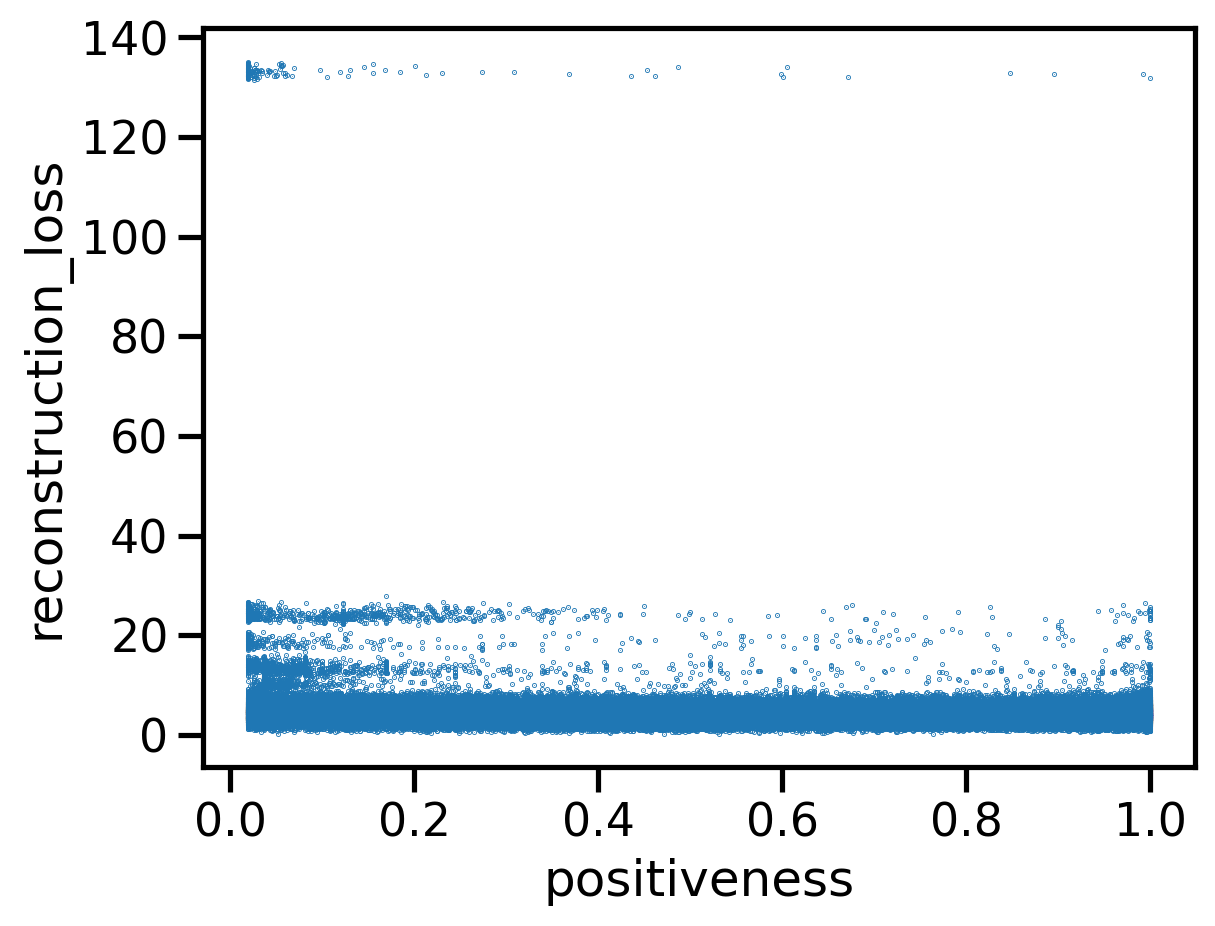

In [115]:
ax = df.plot.scatter(x = 'positiveness', y = 'reconstruction_loss', s=0.1)
fig = ax.get_figure()
mlflow.log_figure(fig, "train_positiveness_reconstruction.png")

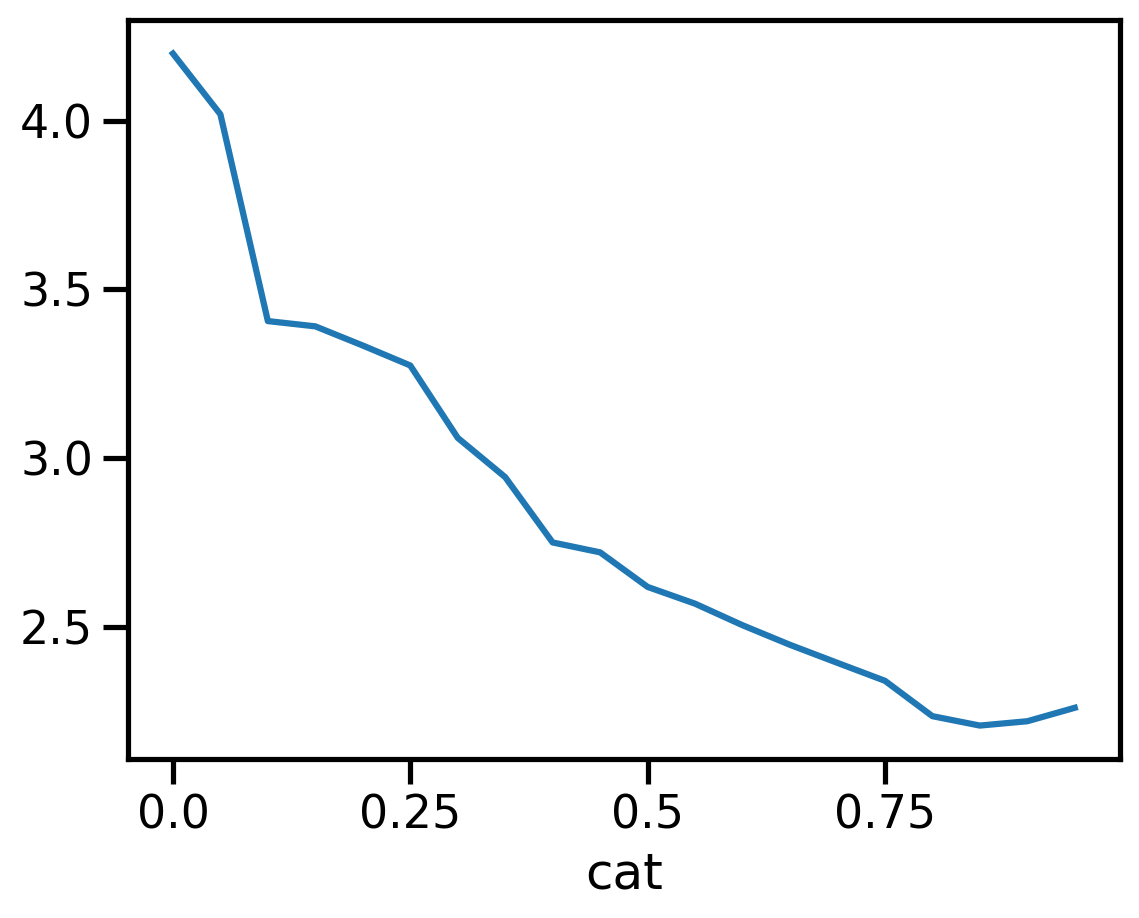

In [ ]:
df['cat'] = pd.cut(df['positiveness'], list(np.arange(0,1,0.05))+[1], labels=list(np.arange(0,1,0.05)))
ax = df.groupby('cat')['reconstruction_loss'].mean().plot()
fig = ax.get_figure()
mlflow.log_figure(fig, "train_positiveness_reconstruction_curve.png")

In [ ]:
n_samples = 1_000
n_runs = 1
k = 300

mlflow.log_params({
    'inference_samples': n_samples,
    'top_k': k
})

ours_generated_dfs = list()

batch_size = 128
#batch_data = validation[: batch_size]
batch_data = train

batch_data = batch_data.groupby(features['context_features']['features_order']).first().reset_index()
batch_data = batch_data.loc[np.repeat(batch_data.index, batch_size)]

#chosen_context = ('Oil', '3.0')
#batch_data = batch_data[(batch_data.advertiser_category_context==chosen_context[0])&(batch_data.adexchange_context==chosen_context[1])].reset_index().iloc[[0]*batch_size]

data_ix_tensors = df_to_ix_tensors(batch_data, features)

for i in range(n_runs):
    generated_dfs = []

    with torch.no_grad():
        total_loss = 0
        if n_samples > 1:
            model.train()
        else:
            model.eval()


        for _ in tqdm(range(n_samples)):
            output = model(data_ix_tensors)

            generated_data_ix_tensors, confidences = generated_to_data_ix_tensors(output, data_ix_tensors, features)
            with torch.no_grad():
                estimator.eval()
                estimator_output = estimator(generated_data_ix_tensors)
                estimator_output = F.softplus(estimator_output)
                estimated_scores = denormalizers[performance_columns[0]](chosen_dist(estimator_output).mean)

            tmp = dict()
            for s_feature in features['strategy_features']['features_order']:
                tmp[s_feature] = output[s_feature].detach().argmax(1).cpu().numpy()
            generated = pd.DataFrame.from_dict(tmp)
            generated[features['context_features']['features_order']] = batch_data[features['context_features']['features_order']].values
            generated['generated_score'] = estimated_scores.detach().cpu().numpy()
            generated['real_mean_score'] = stats.loc[generated[features['context_features']['features_order']].to_records(index=False).tolist()]['mean'].values
            generated = generated[features['context_features']['features_order']+features['strategy_features']['features_order']+['generated_score', 'real_mean_score']]
            generated_dfs.append(generated)
    generated = pd.concat(generated_dfs).groupby(features['context_features']['features_order'] + features['strategy_features']['features_order']).mean().reset_index()
    generated = generated.set_index(features['context_features']['features_order'])
    mapped = generated.copy()
    for feat, feat_dict in list(features['strategy_features']['features'].items()) + list(features['context_features']['features'].items()):
        mapped.replace({feat: feat_dict['ix_to_value']}, inplace=True)
    top_k_generated = mapped.sort_values(by=['generated_score'], ascending=False).groupby(features['context_features']['features_order']).head(k)
    ours_generated_dfs.append(top_k_generated)

In [139]:
top_k_generated = pd.concat(ours_generated_dfs).sort_values(by=['generated_score'], ascending=False).groupby(features['context_features']['features_order']).head(300)
top_k_generated

region       os browser  \
advertiser_category_context   adexchange_context                           
Telecom                       1.0                   134  windows   opera   
Footwear                      1.0                    94  windows   other   
                              1.0                    94  windows   other   
                              1.0                   164  windows   other   
                              1.0                    94  windows   other   
...                                                 ...      ...     ...   
Mobile e-commerce app install 0.0                   333  windows   other   
                              0.0                   134      ios   other   
                              0.0                    94  windows   other   
                              0.0                   164  windows   opera   
                              0.0                   134      mac   other   

                                                   gender slotvisibility  \
advertiser_category_context   adexchange_context                           
Telecom                       1.0                    Male              2   
Footwear                      1.0                    Male      FirstView   
                              1.0                    Male     SecondView   
                              1.0                 Unknown              0   
                              1.0                    Male      FirstView   
...                                                   ...            ...   
Mobile e-commerce app install 0.0                 Unknown             Na   
                              0.0                 Unknown      FirstView   
                              0.0                    Male             Na   
                              0.0                 Unknown      FirstView   
                              0.0                 Unknown      FirstView   

                                                 slotformat  slotwidth  \
advertiser_category_context   adexchange_context                         
Telecom                       1.0                         1        910   
Footwear                      1.0                         1        300   
                              1.0                         1        300   
                              1.0                         1        300   
                              1.0                         1        300   
...                                                     ...        ...   
Mobile e-commerce app install 0.0                         1        960   
                              0.0                         1        300   
                              0.0                         1        960   
                              0.0                         1        300   
                              0.0                         0        910   

                                                  slotheight  generated_score  \
advertiser_category_context   adexchange_context                                
Telecom                       1.0                         60       225.707596   
Footwear                      1.0                         50       224.843399   
                              1.0                         50       221.698364   
                              1.0                        250       221.376740   
                              1.0                         80       220.875748   
...                                                      ...              ...   
Mobile e-commerce app install 0.0                        250        98.398941   
                              0.0                        250        98.397064   
                              0.0                        280        98.350510   
                              0.0                        600        98.316536   
                              0.0                        250        98.291847   

                                                  real

In [36]:
top_k_generated_dict = {}
for k in [10, 30, 50, 100, 200, 300]:
    top_k_generated_dict[k] = top_k_generated.sort_values(by=['generated_score'], ascending=False).groupby(features['context_features']['features_order']).head(k)

In [143]:
top_k_path = 'mlflow_artifacts/asgar_top_k_generated.csv'
top_k_generated.to_csv(top_k_path)
mlflow.log_artifact(top_k_path)

In [106]:
top_k_generated = pd.read_csv('mlflow_artifacts/asgar_top_k_generated.csv')
for k,v in train.dtypes.to_dict().items():
    if k not in top_k_generated.columns:
        continue
    if v == np.dtype('O'):
        v = np.dtype(str)
    top_k_generated[k] = top_k_generated[k].astype(v)
top_k_generated[context_columns] = top_k_generated[context_columns].astype(str)
top_k_generated = top_k_generated.set_index(context_columns)
top_k_generated

region       os browser  \
advertiser_category_context   adexchange_context                           
Telecom                       1.0                   134  windows   opera   
Footwear                      1.0                    94  windows   other   
                              1.0                    94  windows   other   
                              1.0                   164  windows   other   
                              1.0                    94  windows   other   
...                                                 ...      ...     ...   
Mobile e-commerce app install 0.0                   333  windows   other   
                              0.0                   134      ios   other   
                              0.0                    94  windows   other   
                              0.0                   164  windows   opera   
                              0.0                   134      mac   other   

                                                   gender slotvisibility  \
advertiser_category_context   adexchange_context                           
Telecom                       1.0                    Male              2   
Footwear                      1.0                    Male      FirstView   
                              1.0                    Male     SecondView   
                              1.0                 Unknown              0   
                              1.0                    Male      FirstView   
...                                                   ...            ...   
Mobile e-commerce app install 0.0                 Unknown             Na   
                              0.0                 Unknown      FirstView   
                              0.0                    Male             Na   
                              0.0                 Unknown      FirstView   
                              0.0                 Unknown      FirstView   

                                                 slotformat  slotwidth  \
advertiser_category_context   adexchange_context                         
Telecom                       1.0                         1        910   
Footwear                      1.0                         1        300   
                              1.0                         1        300   
                              1.0                         1        300   
                              1.0                         1        300   
...                                                     ...        ...   
Mobile e-commerce app install 0.0                         1        960   
                              0.0                         1        300   
                              0.0                         1        960   
                              0.0                         1        300   
                              0.0                         0        910   

                                                  slotheight  generated_score  \
advertiser_category_context   adexchange_context                                
Telecom                       1.0                         60       225.707600   
Footwear                      1.0                         50       224.843400   
                              1.0                         50       221.698360   
                              1.0                        250       221.376740   
                              1.0                         80       220.875750   
...                                                      ...              ...   
Mobile e-commerce app install 0.0                        250        98.398940   
                              0.0                        250        98.397064   
                              0.0                        280        98.350510   
                              0.0                        600        98.316536   
                              0.0                        250        98.291850   

                                                  real

In [34]:
p = list()
batch_size = 1024
for i in tqdm(range(0, len(train), batch_size)):
    batch_data = train[i: i+batch_size]

    data_ix_tensors = df_to_ix_tensors(batch_data, features)

    output = estimator(data_ix_tensors)
    output_softplus = F.softplus(output)

    normals = chosen_dist(output_softplus)

    p += denormalizers[performance_columns[0]](normals.mean).tolist()
train['estimated_score'] = p
train

100%|██████████| 152/152 [00:03<00:00, 43.09it/s] 


,advertiser_category_context,adexchange_context,region,os,browser,gender,slotvisibility,slotformat,slotwidth,slotheight,score,estimated_score
39081,Footwear,4.0,374,windows,firefox,Female,FirstView,Na,300,250,120.000000,58.273857
108715,Software,2.0,146,windows,theworld,Male,1,0,728,90,81.625000,82.963989
126506,Telecom,1.0,65,mac,other,Unknown,FirstView,Na,300,250,80.000000,142.716858
33235,Footwear,3.0,0,windows,chrome,Unknown,Na,Na,300,250,127.613537,133.449280
37735,Footwear,4.0,216,windows,safari,Female,SecondView,Na,300,250,36.000000,67.044205
...,...,...,...,...,...,...,...,...,...,...,...,...
28671,Footwear,2.0,106,windows,ie,Unknown,Na,Na,336,280,124.500000,87.429832
15365,Chinese vertical e-commerce,2.0,94,mac,chrome,Unknown,0,0,160,600,40.000000,140.849182
114887,Software,2.0,94,windows,chrome,Unknown,2,0,200,200,49.166667,49.611496
56157,International e-commerce,2.0,276,windows,ie,Female,0,0,728,90,97.383886,95.288216


Text(0.5, 1.0, 'Mean Generated Score by top K')

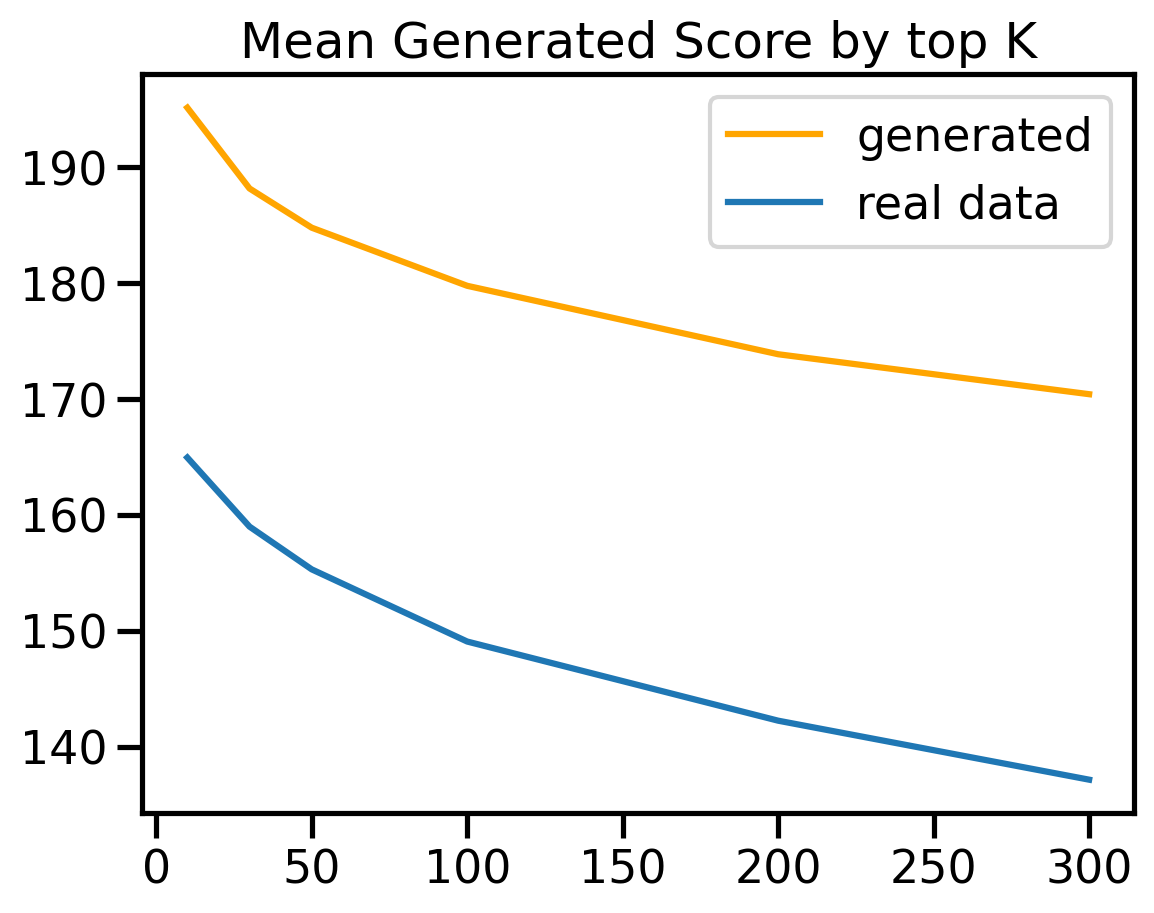

In [ ]:
fig = plt.figure()
ks = list()
means = list()
real_means = list()
for k in top_k_generated_dict:
    ks.append(k)
    means.append(top_k_generated_dict[k]['generated_score'].mean())
    real_means.append(train.drop_duplicates().sort_values(by=['estimated_score'], ascending=False).groupby(features['context_features']['features_order']).head(k)['estimated_score'].mean())
    
plt.plot(ks, means, color='orange', label='generated')
plt.plot(ks, real_means, label='real data')
plt.legend()
plt.title('Mean Generated Score by top K')
mlflow.log_figure(fig, "mean_generated_scores_by_top_k_with_real_data.png")

In [147]:
from scipy.spatial.distance import hamming

for k in top_k_generated_dict:
    cols = features['strategy_features']['features_order']
    top_k_tmp = top_k_generated.drop_duplicates().sort_values(by=['generated_score'], ascending=False).groupby(features['context_features']['features_order']).head(k)
    our_hammings_dict = dict()
    for current_context in tqdm(top_k_tmp.index.unique()):
        my_results = top_k_tmp.loc[[current_context]]
        ours_generated_dfs = [my_results]
        cdf = train[(train.advertiser_category_context==current_context[0])&(train.adexchange_context==current_context[1])].drop_duplicates()
        cdf = cdf.set_index(['advertiser_category_context', 'adexchange_context'])
        cdf = cdf[cdf['estimated_score'] >= cdf['estimated_score'].mean()]
        
        cdfmat = cdf[cols].values

        all_our_hammings = list()
        for i in range(len(ours_generated_dfs)):
            
            hammings = list()
            for i, garr in enumerate(ours_generated_dfs[i][cols].values):
                tmp = []
                for cdfarr in cdfmat:
                    tmp.append(hamming(garr, cdfarr))
                hammings.append(min(tmp))
            our_hamming = np.mean(hammings)
            all_our_hammings.append(our_hamming)
            #print(f'Top {k} Mean Hamming Distance to real data :\t{our_hamming:2.3f}')
        our_hammings_dict[current_context] = np.mean(all_our_hammings)
        #print(f'Context {current_context} Generated Top {len(my_results)} Mean Hamming Distance to real data :\t{our_hamming:2.3f}')

    hamming_result = np.mean(list(our_hammings_dict.values()))
    print(f'Top {k} All Contexts mean hamming distance {hamming_result:1.3f}')
    mlflow.log_metric(f'top {k} hamming distance', hamming_result)

100%|██████████| 26/26 [04:40<00:00, 10.79s/it]


Top 10 All Contexts mean hamming distance 0.352
Top 30 All Contexts mean hamming distance 0.346
Top 50 All Contexts mean hamming distance 0.345
Top 100 All Contexts mean hamming distance 0.344
Top 200 All Contexts mean hamming distance 0.339
Top 300 All Contexts mean hamming distance 0.339


(0.0, 1.0)

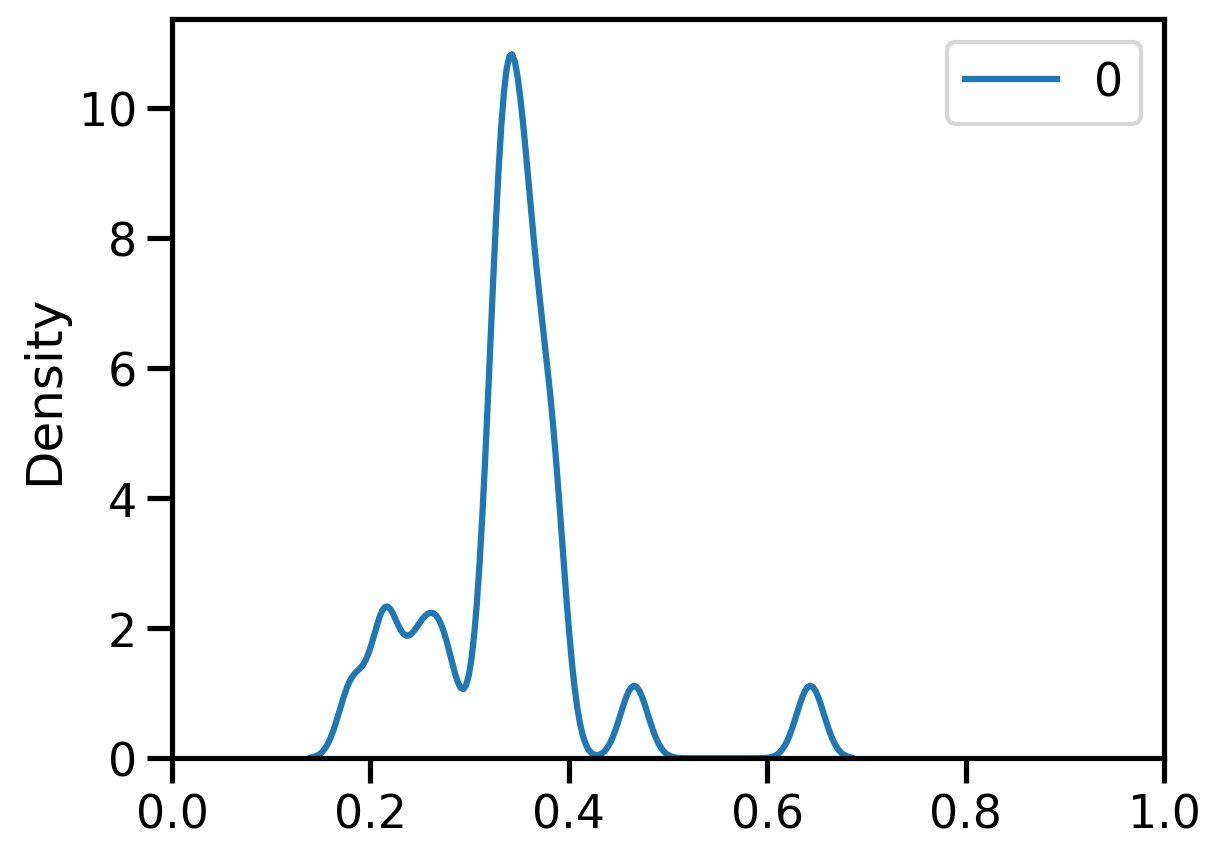

In [148]:
sns.kdeplot(our_hammings_dict.values(), bw_adjust=0.3)
#sns.histplot(our_hammings_dict.values(), bins=15)
plt.xlim(left=0, right=1)

In [39]:
def ix_tensors_to_concat_embeddings(ix_tensors, estimator):
    with torch.no_grad():
        concat_embeddings = list()
        for col in estimator.module.features['strategy_features']['features_order']:
            d = estimator.module.features['strategy_features']['features'][col]
            ixs = ix_tensors['strategy_features'][col].detach().flatten().view(-1,1)
            value_embedding = estimator.module.embeddings['item_embeddings'][col](ixs) #shape: (batch_size, current_feature_vocab_len, emb_dim)

            final_embedding = value_embedding #+ type_embedding #shape: (batch_size, current_feature_vocab_len, emb_dim)
            final_embedding = final_embedding.squeeze(1)
            concat_embeddings.append(final_embedding)
        concat_embeddings = torch.cat(concat_embeddings, 1)
        return concat_embeddings

def cosine_sim(gen_embs, data_embs, emb_dim=0, per_feature=False):
    if per_feature:
        assert emb_dim > 0
        l = len(data_embs)
        cosines = list()
        for i in range(len(features['strategy_features']['features_order'])):
            cosi = F.cosine_similarity(data_embs.view((l, emb_dim, -1))[:,:,i], gen_embs.view((l, emb_dim, -1))[:,:,i])
            cosines.append(cosi.cpu().numpy())
        return np.array(cosines).mean(axis=0).max()
    else:
        return F.cosine_similarity(gen_embs, data_embs).max().item()

In [ ]:
for k in top_k_generated_dict:
    cols = features['strategy_features']['features_order']
    top_k_tmp = top_k_generated.drop_duplicates().sort_values(by=['generated_score'], ascending=False).groupby(features['context_features']['features_order']).head(k)
    our_hammings_dict = dict()
    for current_context in tqdm(top_k_tmp.index.unique()):
        my_results = top_k_tmp.loc[[current_context]]
        ours_generated_dfs = my_results
        cdf = train[(train.advertiser_category_context==current_context[0])&(train.adexchange_context==current_context[1])].drop_duplicates()
        cdf = cdf.set_index(['advertiser_category_context', 'adexchange_context'])
        cdf = cdf[cdf['estimated_score'] >= cdf['estimated_score'].mean()]
        
        all_out_cosine = list()

        for i in range(len(my_results)):
            gen_ix_tensors = df_to_ix_tensors(my_results.iloc[[i]*len(cdf)].reset_index(), features)
            dat_ix_tensors = df_to_ix_tensors(cdf.reset_index(), features)
            data_embs = ix_tensors_to_concat_embeddings(dat_ix_tensors, estimator)
            gen_embs = ix_tensors_to_concat_embeddings(gen_ix_tensors, estimator)
            max_cosine_sim = cosine_sim(gen_embs, data_embs, emb_dim=estimator.module.embedding_dim, per_feature=True)
            all_out_cosine.append(max_cosine_sim)
        my_results['cosine_sim'] = all_out_cosine
    cosine_result = np.mean(all_out_cosine)
    print_tqdm(f'Top {k} All Contexts mean cosine sim {cosine_result:1.3f}')
    mlflow.log_metric(f'top_{k}_mean_cosine_similarity', cosine_result)

100%|██████████| 26/26 [00:03<00:00,  6.98it/s]
Top 10 All Contexts mean cosine sim 0.593
100%|██████████| 26/26 [00:09<00:00,  2.71it/s]
Top 30 All Contexts mean cosine sim 0.640
100%|██████████| 26/26 [00:15<00:00,  1.67it/s]
Top 50 All Contexts mean cosine sim 0.705
100%|██████████| 26/26 [00:30<00:00,  1.17s/it]
Top 100 All Contexts mean cosine sim 0.765
100%|██████████| 26/26 [00:59<00:00,  2.30s/it]
Top 200 All Contexts mean cosine sim 0.791
100%|██████████| 26/26 [01:29<00:00,  3.43s/it]
Top 300 All Contexts mean cosine sim 0.797


In [149]:
# SAVE BEFORE
!jupyter nbconvert --to html ASGAR.ipynb
mlflow.log_artifact('ASGAR.ipynb')
mlflow.log_artifact('ASGAR.html')

mlflow.end_run()

[NbConvertApp] Converting notebook good_data_strategy_parallel_runs.ipynb to html
[NbConvertApp] Writing 10431604 bytes to good_data_strategy_parallel_runs.html
